
## R에서 간단한 처리 이후 이쪽으로 분석 진행. 
### 처리내역 :
#### Outlier 및 NA observation 처리 : 
* 4분 이하, 4000분 이상 데이터 삭제
* confidence NA 변수 5000여개 삭제
* Salary 중 Student가 높은 salary 갖는 몇 안되는 개체 삭제
* gender = 총 4개의 그룹 중 2개의 small class의 개체들이 다른 패턴 보유, 삭제
* salary = I do not want to disclose 개체 삭제(우리가 관심있는 것은 연봉을 밝힌 사람들 중 고액연봉자들의 패턴이기 때문에) 

#### 변수 One Hot Encoding : 
* 기존에 One Hot Encoding 되어있는 변수들은 0, 1 로 재코딩
* class를 보유하고 있는 단일변수들은 one hot encoding (get_dummies) 하여 여러 변수로 나누어줌. (ex - Role, Industry, gender, ...)
* 척도형 변수를 갖는 단일 변수도 예외없이 one hot encoding 시킴
* Q34, Q35 = 변수설명상 합쳐서 100이 되는 변수 - 각 개체 값이 1 이하가 되도록 100으로 나눠줌
* 변수 설명상 0~3의 값을 적는 변수 - 각 개체 값이 1 이하가 되도록 3으로 나눠줌. 
* 7_Student : industry = Student인 경우와 Role = Student인 경우가 중첩되어 Industry = Student 변수 삭제. 

* **Role = 앞에서 Data Scientist 효과가 미미해져버린 문제가 생겨 다시코딩. 1. Data Scientiest. 2. Data Analyst 3. Software Engineer 4. DBA/Data Engineer 5. Student  6. Statistician/Research_Analyst 7. Consultant/Manager 8. Other**
* Role의 나머지 class들은 분포가 너무 상이해서 합칠수가 없었다. Other로 배치 시 Other의 기존 분포와도 차이가 심해서 Other의 salary에 미치는 영향이 너무 크게 나타나 버린다. (레포트에 추가해놓으시면 R 그래프 첨부해 놓을께요) 

* **Confidence level 3개로 재코딩**
* **28, 29, 30 변수들 AWS, Google, Azure, Microsoft, IBM으로 라벨링**

#### 삭제한 변수 내역 : 
* Q17, 18, 20, 22, 33은 전과 같은 이유로 제거 
* Q41 - 앞의 모든 경우에서 multicollinearity가 발견되어 삭제. 
* Q2 - Male : Female과 correlation 0.9 이상으로 제거
* Q7-Student : Q6의 Student와 index가 맞게 맞춰놓았기 때문에 제거. 
* Q34 : 일반적으로 데이터 사이언스 프로젝트 진행 시 각 업무별로 소요되는 시간 비중 => 앞의 모든 경우에서 변수가 유의하게 나와 한번 빼고 진행. 
(Q34, Q35는 넣고 빼고 둘다 진행해보기)
* Q34, Q35 모두 넣었을 경우 수치형 변수때문에 다른 변수의 효과들이 견인되어 버리는 문제가 발생. ( DS의 coefficient가 0으로 당겨져 버리는 문제 발생) 따라서 빼고 진행해보기로 함.
* Q43 : 진행한 data projects 중 데이터셋내의 'unfair bias'의 탐구와 관련이 있었던 프로젝트의 비율 => 너무 많은 class로 제거
* Q44 : fair 하고 unbiased 한 알고리즘을 확실히 하는 데 가장 많은 어려움을 주는 항목 : 복수 응답 : ex. difficulty in identifying groups that are unfairly targeted. => 역시 너무 많은 class로 제거. 
* (앞의 경우 Q43, Q44 모두 Variable Importance 20 내에 들지 못함) 
* Q43, Q46 제거함. (척도가 너무 많음. Data Dim Reduction을 위해서. 이전 실험에서 Variable Importance 20 안에 들지 못함.) 
* 이외에, Overfitting을 피하기 위해 전체 데이터 개체 수 중 5% 미만의 응답을 갖는 variable(one hot encoded) 해당 class를 제거함. (전체 중 5% 미만이라 함은, 거의 600 이하의 응답수를 갖고 있음을 의미하고, 이를 가지고 Training 등을 시키게 되면 너무 작은 특징에도 fitting되는 overfitting이 우려되어 부득이하게 해당 변수 중 그 class를 제거했다. + Dim Reduction 측면에서도 용이. 450여개 -> 245개로 줄일 수 있었음.) 

#### Target Variable Salary 변형 : 
* 총 19개의 multiclass를 가지고 있어, multiclassification 하게 되면 성능이 너무 낮아지는 문제가 발생하여 상위 20%에게 1, 하위 80%에게 0 label을 갖는 top_20 변수를 새로 생성함. 




In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
multiple = pd.read_csv("/content/drive/My Drive/multiple3.csv", low_memory = False)

In [ ]:
qschema = pd.read_csv("/content/drive/My Drive/SurveySchema.csv")

In [ ]:
multiple.head()

,duration,gender,Age,country,degree,undergraduate_major,Role,industry,Experience,value,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q14_Part_1,Q14_Part_2,...,Q47_Part_11,Q47_Part_12,Q47_Part_13,Q47_Part_14,Q47_Part_15,Q47_Part_16,Q48,Q49_Part_1,Q49_Part_2,Q49_Part_3,Q49_Part_4,Q49_Part_5,Q49_Part_6,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4
0,710,Female,45-49,NorthAmerica,Doctoral degree,Other,Consultant/Project/Manager,Other,NaN,I do not wish to disclose my approximate yearl...,I do not know,Analyze and understand data to influence produ...,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,Do research that advances the state of the art...,NaN,NaN,-1,-1,-1,-1,0,Jupyter/IPython,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Azure,NaN,NaN,NaN,NaN,Microsoft,NaN,NaN,NaN,NaN
1,434,Male,30-34,Asia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000",No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,718,Female,30-34,NorthAmerica,Master’s degree,"Computer science (software engineering, etc.)",Student,Student,0-1,"0-10,000",I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,I am confident that I can explain the outputs ...,NaN,NaN,NaN,NaN,NaN,NaN,Make sure the code is human-readable,Define all random seeds,NaN,Include a text file describing all dependencies,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,731,Male,22-24,Asia,Master’s degree,Mathematics or statistics,Student,Student,0-1,"0-10,000",I do not know,NaN,NaN,NaN,NaN,NaN,NaN,Other,-1,1,-1,-1,-1,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,I am confident that I can understand and expla...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Define relative rather than absolute file paths,NaN,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,NaN,Google,NaN,Azure,NaN,NaN,IBM,NaN,NaN,NaN,Google,NaN,NaN
4,1142,Male,25-29,SouthAmerica,Bachelor’s degree,Physics or astronomy,Data Scientist,Computers/Technology,0-1,I do not wish to disclose my approximate yearl...,We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,NaN,NaN,-1,-1,-1,2,-1,Jupyter/IPython,NaN,NaN,NaN,NaN,Atom,NaN,NaN,NaN,NaN,Vim,NaN,NaN,NaN,NaN,Kaggle Kernels,Google Colab,...,NaN,NaN,NaN,NaN,NaN,NaN,"I view ML models as ""black boxes"" but I am con...",Share code on Github or a similar code-sharing...,Share both data and code on Github or a simila...,"Share data, code, and environment using a host...",NaN,"Share code, data, and environment using virtua...",Make sure the code is well documented,Make sure the code is human

In [ ]:
## drop Nan in salary
#multiple = multiple[~multiple.value.isnull()].copy()
not_disclosed = multiple[multiple.value == 'I do not wish to disclose my approximate yearly compensation'].index
#multiple = multiple.drop(list(not_disclosed), axis=0)
print(not_disclosed)

Int64Index([    0,     4,     8,    17,    25,    28,    31,    42,    49,
               59,
            ...
            16472, 16476, 16477, 16480, 16481, 16483, 16485, 16489, 16490,
            16495],
           dtype='int64', length=4003)


In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
multiple.dtypes

duration       int64
gender        object
Age           object
country       object
degree        object
               ...  
Q29_Part_5    object
Q30_Part_1    object
Q30_Part_2    object
Q30_Part_3    object
Q30_Part_4    object
Length: 293, dtype: object

In [ ]:
multiple.columns

Index(['duration', 'gender', 'Age', 'country', 'degree', 'undergraduate_major',
       'Role', 'industry', 'Experience', 'value',
       ...
       'Q28_Part_4', 'Q29_Part_1', 'Q29_Part_2', 'Q29_Part_3', 'Q29_Part_4',
       'Q29_Part_5', 'Q30_Part_1', 'Q30_Part_2', 'Q30_Part_3', 'Q30_Part_4'],
      dtype='object', length=293)

In [ ]:
multiple.iloc[:,319:321]

""
0
1
2
3
4
...
16491
16492
16493
16494


## Another Dataset : 
* Student가 I do not disclose my compensation의 45%를 차지
* gender 2개에서 이상치 생김. 아예 drop하는게? 
* Students 패턴 제거 (수입 적음) 

In [ ]:
gender_trolls = multiple[(multiple.gender == 'Prefer to self-describe') | (multiple.gender == 'Prefer not to say')].index
multiple = multiple.drop(list(gender_trolls), axis=0)

In [ ]:
student_trolls = multiple[((multiple.Role == 'Student') & (multiple.value > '500,000+')) | \
                     ((multiple.Role == 'Student') & (multiple.value > '400-500,000')) | \
                     ((multiple.Role == 'Student') & (multiple.value > '300-400,000')) | \
                     ((multiple.Role == 'Student') & (multiple.value > '250-300,000'))].index
multiple = multiple.drop(list(student_trolls), axis=0)

In [ ]:
multiple = multiple[~multiple.value.isnull()].copy()
not_disclosed = multiple[multiple.value == 'I do not wish to disclose my approximate yearly compensation'].index
multiple = multiple.drop(list(not_disclosed), axis=0)

In [ ]:
multiple.value[1:10]

2        0-10,000
3        0-10,000
5       10-20,000
6        0-10,000
7       20-30,000
9     125-150,000
11      10-20,000
12      30-40,000
13      50-60,000
Name: value, dtype: object

In [ ]:
question = multiple.columns

In [ ]:
question[100:300]

Index(['Q21_Part_8', 'Q21_Part_9', 'Q21_Part_10', 'Q21_Part_11', 'Q21_Part_12',
       'Q21_Part_13', 'Q23', 'Q24', 'Q25', 'confidence',
       ...
       'Q28_Part_4', 'Q29_Part_1', 'Q29_Part_2', 'Q29_Part_3', 'Q29_Part_4',
       'Q29_Part_5', 'Q30_Part_1', 'Q30_Part_2', 'Q30_Part_3', 'Q30_Part_4'],
      dtype='object', length=193)

In [ ]:
multiple.dtypes[10:20]

Q10                object
Q11_Part_1         object
Q11_Part_2         object
Q11_Part_3         object
Q11_Part_4         object
Q11_Part_5         object
Q11_Part_6         object
Q11_Part_7         object
Q12_Part_1_TEXT     int64
Q12_Part_2_TEXT     int64
dtype: object

## One Hot Encoding : 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
sns.set_style('dark')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* Role : 

In [ ]:
len(multiple.Role[multiple.Role.isna()])

0

In [ ]:
roledummy = pd.get_dummies(multiple.Role)

In [ ]:
roledummy.head()

,Consultant/Project/Manager,Data Analyst,Data Engineer/DBA,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
5,0,0,0,0,1,0,0,0
6,0,0,0,0,1,0,0,0


* Q1 - Q10 - gender

In [ ]:
multiple.gender.unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
sex = pd.get_dummies(multiple.gender).iloc[:,:2]
sex.columns=list(map(lambda x:'1_'+x,sex.columns))

In [ ]:
sex[1:10]

,1_Female,1_Male
2,1,0
3,0,1
5,0,1
6,0,1
7,0,1
9,0,1
11,1,0
12,0,1
13,0,1


In [ ]:
ndata = multiple.iloc[:,0]
ndata.head()

1     434
2     718
3     731
5     959
6    1758
Name: duration, dtype: int64

In [ ]:
ndata = pd.concat([ndata,sex],axis=1)
ndata.head()

,duration,1_Female,1_Male
1,434,0,1
2,718,1,0
3,731,0,1
5,959,0,1
6,1758,0,1


* Q1 - Q10 : 나이

In [ ]:
multiple.Age.unique()

array(['30-34', '22-24', '35-39', '18-21', '40-44', '25-29', '55-59',
       '60-69', '45-49', '50-54', '70-79', '80+'], dtype=object)

In [ ]:
q2=pd.get_dummies(multiple.Age)
q2.columns=list(map(lambda x: '2_'+x,q2.columns))
ndata = pd.concat([ndata,q2],axis=1)

country - one hot encoding 

In [ ]:
multiple.country.unique()

array(['Asia', 'NorthAmerica', 'SouthAmerica', 'Europe', 'Africa',
       'Oceania', nan], dtype=object)

In [ ]:
q3=pd.get_dummies(multiple.country)

In [ ]:
q3.columns=list(map(lambda x: '3_'+x,q3.columns))
ndata = pd.concat([ndata,q3],axis=1)

In [ ]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12190 entries, 1 to 16494
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   duration        12190 non-null  int64
 1   1_Female        12190 non-null  uint8
 2   1_Male          12190 non-null  uint8
 3   2_18-21         12190 non-null  uint8
 4   2_22-24         12190 non-null  uint8
 5   2_25-29         12190 non-null  uint8
 6   2_30-34         12190 non-null  uint8
 7   2_35-39         12190 non-null  uint8
 8   2_40-44         12190 non-null  uint8
 9   2_45-49         12190 non-null  uint8
 10  2_50-54         12190 non-null  uint8
 11  2_55-59         12190 non-null  uint8
 12  2_60-69         12190 non-null  uint8
 13  2_70-79         12190 non-null  uint8
 14  2_80+           12190 non-null  uint8
 15  3_Africa        12190 non-null  uint8
 16  3_Asia          12190 non-null  uint8
 17  3_Europe        12190 non-null  uint8
 18  3_NorthAmerica  12190 non-

Degree - 교육수준 one hot encoding! 

In [ ]:
multiple.degree.unique()

array(['Bachelor’s degree', 'Master’s degree', 'Doctoral degree',
       'Professional degree',
       'Some college/university study without earning a bachelor’s degree',
       'No formal education past high school'], dtype=object)

In [ ]:
q4 = pd.get_dummies(multiple.degree)
q4.columns=list(map(lambda x: '4_'+x,q4.columns))
ndata = pd.concat([ndata,q4],axis=1)

* Role 추가 

In [ ]:
ndata = pd.concat([ndata, roledummy], axis=1)

Major in undergraduated : 

In [ ]:
multiple.undergraduate_major.unique()

array(['Engineering (non-computer focused)',
       'Computer science (software engineering, etc.)',
       'Mathematics or statistics',
       'Information technology, networking, or system administration',
       'A business discipline (accounting, economics, finance, etc.)',
       'Environmental science or geology',
       'Medical or life sciences (biology, chemistry, medicine, etc.)',
       'I never declared a major', 'Other', 'Physics or astronomy',
       'Social sciences (anthropology, psychology, sociology, etc.)',
       'Humanities (history, literature, philosophy, etc.)', nan,
       'Fine arts or performing arts'], dtype=object)

In [ ]:
q5 = pd.get_dummies(multiple.undergraduate_major)
q5.columns=list(map(lambda x: '5_'+x,q5.columns))
ndata = pd.concat([ndata,q5],axis=1)

* Industry : 산업군! 

In [ ]:
q7 = pd.get_dummies(multiple.industry)
q7.columns=list(map(lambda x: '7_'+x,q7.columns))
ndata = pd.concat([ndata,q7],axis=1)

* Salary - Target variable! 

* experience 

In [ ]:
q8 = pd.get_dummies(multiple.Experience)
q8.columns=list(map(lambda x: '8_'+x,q8.columns))
ndata = pd.concat([ndata,q8],axis=1)

* Q10 - ML 회사 사용? 

In [ ]:
multiple.columns[1:15]

Index(['gender', 'Age', 'country', 'degree', 'undergraduate_major', 'Role',
       'industry', 'Experience', 'value', 'Q10', 'Q11_Part_1', 'Q11_Part_2',
       'Q11_Part_3', 'Q11_Part_4'],
      dtype='object')

In [ ]:
ndata.shape

(12190, 78)

In [ ]:
# to dummies : 
q10 = pd.get_dummies(multiple.Q10)
q10.columns=list(map(lambda x: '10_'+x,q10.columns))
ndata = pd.concat([ndata,q10],axis=1)

In [ ]:
ndata.shape

(12190, 84)

* Q11

In [ ]:
def to_onehot(i):
    num = 'Q'+str(i)
    q = multiple[[t for t in multiple.columns if num in t]]
    q = q.drop([t for t in q.columns if 'OTHER_TEXT' in t],axis=1)  
    q=q.fillna(0)
    q_r = []
    for col in q.columns:
        if q[col].unique()[0]!=0:
            s = q[col].unique()[0]
            q_r.append(s)
        else:
            s = q[col].unique()[1]
            q_r.append(s)
        q[col]=q[col].replace(s,1)
    q.columns=q_r
    return q

In [ ]:
q11=to_onehot(11)
q11=q11.idxmax(axis=1)
q11.head()

1    None of these activities are an important part...
2    Analyze and understand data to influence produ...
3                                                Other
5    None of these activities are an important part...
6    Build and/or run a machine learning service th...
dtype: object

In [ ]:
q11=to_onehot(11)
q11.columns = ['11_'+str(col) for col in q11.columns]

In [ ]:
#Add None of these & Others - to others
q11.iloc[:,-1]=q11.iloc[:,-2]+q11.iloc[:,-1]
q11=q11.drop(q11.columns[-2],axis=1)

In [ ]:
ndata=pd.concat([ndata,q11],axis=1)

## 원래부터 One-Hot Encoding 된 것들 : Nan -> 0로 바꾸기. 

* Q12

In [ ]:
q12=multiple[[t for t in multiple.columns if 'Q12' in t]]
q12=q12.iloc[:,1:]
q12=q12.astype(int) 
q12[q12!=-1]=1
q12[q12==-1]=0
q12.head()

,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT
1,0,0,0,0
2,0,0,1,0
3,1,0,0,0
5,0,0,0,0
6,0,0,1,0


In [ ]:
q12.columns=['12_'+ str(col) for col in q12.columns]
ndata=pd.concat([ndata,q12],axis=1)

* Q13

In [ ]:
def preprocess_multiple(data,i):
    s='Q'+str(i)
    if s+'_OTHER_TEXT' in data.columns:
        data=data.drop([s+'_OTHER_TEXT'],axis=1)
    df=to_onehot(i)
    df.columns=[str(i)+'_'+str(col) for col in df.columns]
    return df

In [ ]:
q13=preprocess_multiple(multiple, 13)
ndata=pd.concat([ndata,q13],axis=1)

In [ ]:
q13.head()

,13_Jupyter/IPython,13_RStudio,13_PyCharm,13_Visual Studio Code,13_nteract,13_Atom,13_MATLAB,13_Visual Studio,13_Notepad++,13_Sublime Text,13_Vim,13_IntelliJ,13_Spyder,13_None,13_Other
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,1,0,1,1,1,0,1,1,0,0


In [ ]:
ndata.shape

(12190, 109)

In [ ]:
ndata.iloc[1:5, 60:74]

,7_Non-profit/Service,7_Online Business/Internet-based Sales,7_Online Service/Internet-based Services,7_Other,7_Retail/Sales,7_Shipping/Transportation,7_Student,8_0-1,8_1-2,8_10-15,8_15-20,8_2-3,8_20-25,8_25-30
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0,1,0,0,0,0,0,0


* Q14

In [ ]:
q14=preprocess_multiple(multiple, 14)
ndata=pd.concat([ndata,q14],axis=1)

* Q15 - Q16

In [ ]:
q15=preprocess_multiple(multiple, 15)
ndata=pd.concat([ndata,q15],axis=1)

In [ ]:
q16=preprocess_multiple(multiple, 16)
ndata=pd.concat([ndata,q16],axis=1)

In [ ]:
preprocess_needed = [19, 21]

In [ ]:
ndata2 = ndata.copy()

In [ ]:
for i in preprocess_needed : 
  q = preprocess_multiple(multiple, i)
  ndata2 = pd.concat([ndata2, q], axis = 1)

* Q 23-Q26 : get_dummies

In [ ]:
q23=pd.get_dummies(multiple.Q23)
q23.columns=['23_'+str(col) for col in q23.columns]
ndata2=pd.concat([ndata2,q23],axis=1)

In [ ]:
lst=['I have never written code and I do not want to learn','I have never written code but I want to learn','< 1 year','1-2 years','3-5 years',   '5-10 years',
       '10-20 years', '20-30 years','30-40 years','40+ years']

In [ ]:
q24=pd.get_dummies(multiple.Q24)
q24.columns=['24_'+str(col) for col in q24.columns]
q24=q24.reindex(columns=list(map(lambda x: '24_'+x,lst)))
ndata2=pd.concat([ndata2,q24],axis=1)

* Q25

In [ ]:
multiple.Q25.unique()

array(['I have never studied machine learning but plan to learn in the future',
       '< 1 year', '2-3 years', '5-10 years', '1-2 years', '3-4 years',
       '4-5 years',
       'I have never studied machine learning and I do not plan to',
       '10-15 years', '20+ years'], dtype=object)

In [ ]:
q25=pd.get_dummies(multiple.Q25)
q25.columns=['25_'+str(col) for col in q25.columns]
ndata2=pd.concat([ndata2,q25],axis=1)

* Q26 : confindence

In [ ]:
tmp = multiple.confidence.copy()
len(tmp[tmp.isna()])

0

In [ ]:
q26=pd.get_dummies(multiple.confidence)
q26.columns=['26_'+str(col) for col in q26.columns]
ndata2=pd.concat([ndata2,q26],axis=1)

In [ ]:
ndata2.head()

,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,2_45-49,2_50-54,2_55-59,2_60-69,2_70-79,2_80+,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,4_No formal education past high school,4_Professional degree,4_Some college/university study without earning a bachelor’s degree,Consultant/Project/Manager,Data Analyst,Data Engineer/DBA,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Environmental science or geology,5_Fine arts or performing arts,...,21_Altair,21_Shiny,21_D3,21_Plotly,21_Bokeh,21_Seaborn,21_Geoplotlib,21_Leaflet,21_Lattice,21_None,21_Other,23_0% of my time,23_1% to 25% of my time,23_100% of my time,23_25% to 49% of my time,23_50% to 74% of my time,23_75% to 99% of my time,24_I have never written code and I do not want to learn,24_I have never written code but I want to learn,24_< 1 year,24_1-2 years,24_3-5 years,24_5-10 years,24_10-20 years,24_20-30 years,24_30-40 years,24_40+ years,25_1-2 years,25_10-15 years,25_2-3 years,25_20+ years,25_3-4 years,25_4-5 years,25_5-10 years,25_< 1 year,25_I have never studied machine learning and I do not plan to,25_I have never studied machine learning but plan to learn in the future,26_Definitely not,26_Definitely yes,26_Maybe
1,434,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,718,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,731,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,959,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
6,1758,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


* Q27-Q31, Q33, Q36, Q38, Q42, Q44, Q45, Q47, Q49, Q50

In [ ]:
preprocess_needed = [27, 28, 29, 30, 31, 36]

In [ ]:
multiple=multiple.drop(['Q38_Part_19'],axis=1)
multiple=multiple.drop(['Q38_Part_20'],axis=1)

In [ ]:
for i in preprocess_needed : 
  q = preprocess_multiple(multiple, i)
  ndata2 = pd.concat([ndata2, q], axis = 1)

In [ ]:
ndata2.iloc[1:5, 300:310]
ndata2.shape

(12190, 294)

In [ ]:
ndata2.head()

,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,2_45-49,2_50-54,2_55-59,2_60-69,2_70-79,2_80+,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,4_No formal education past high school,4_Professional degree,4_Some college/university study without earning a bachelor’s degree,Consultant/Project/Manager,Data Analyst,Data Engineer/DBA,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Environmental science or geology,5_Fine arts or performing arts,...,29_Azure,29_Microsoft,30_Teradata,30_Microsoft Analysis Services,30_Oracle Exadata,30_Oracle Warehouse Builder,30_SAP IQ,30_Snowflake,30_Databricks,30_None,30_Other,30_AWS,30_Google,30_IBM,30_Azure,31_Audio Data,31_Categorical Data,31_Genetic Data,31_Geospatial Data,31_Image Data,31_Numerical Data,31_Sensor Data,31_Tabular Data,31_Text Data,31_Time Series Data,31_Video Data,31_Other Data,36_Udacity,36_Coursera,36_edX,36_DataCamp,36_DataQuest,36_Kaggle Learn,36_Fast.AI,36_developers.google.com,36_Udemy,36_TheSchool.AI,36_Online University Courses,36_None,36_Other
1,434,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,718,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,731,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0
5,959,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,1758,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
ndata3 = pd.DataFrame

In [ ]:
ndata3 = ndata2.copy()

In [ ]:
for i in [38,42,44,45,47,49,50] : 
  q = preprocess_multiple(multiple, i)
  ndata3 = pd.concat([ndata3, q], axis = 1)

In [ ]:
ndata3.iloc[1:4, 310:330]

,38_The Data Skeptic Podcast,38_Medium Blog Posts,38_None/I do not know,38_Other,42_Revenue and/or business goals,42_Metrics that consider accuracy,42_Metrics that consider unfair bias,42_Not applicable (I am not involved with an organization that builds ML models),42_Other,44_Lack of communication between individuals who collect the data and individuals who analyze the data,44_Difficulty in identifying groups that are unfairly targeted,44_Difficulty in collecting enough data about groups that may be unfairly targeted,44_Difficulty in identifying and selecting the appropriate evaluation metrics,44_I have never found any difficulty in this task,44_I have never performed this task,45_Only for very important models that are already in production,45_For all models right before putting the model in production,45_When determining whether it is worth it to put the model into production,45_When building a model that was specifically designed to produce such insights,45_When first exploring a new ML model or dataset
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0
5,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


* Q32

In [ ]:
multiple=multiple.drop(['Q32_OTHER'],axis=1)

* Q34 : 일반적으로 데이터 사이언스 프로젝트 진행 시 각 업무별로 소요되는 시간 비중  =>  빼기. 



In [ ]:
len(multiple.Q34_Part_1[multiple.Q34_Part_1.isna()]) 

1474

In [ ]:
q34=multiple[[t for t in multiple.columns if 'Q34_' in t]]/100
#ndata3=pd.concat([ndata3,q34],axis=1)

In [ ]:
q34.head()

,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,0.03,0.2,0.5,0.20,0.00
3,0.10,0.10,0.2,0.1,0.20,0.23
5,0.00,0.30,0.5,0.0,0.00,0.20
6,0.20,0.30,0.2,0.2,0.05,0.05


* Q35

In [ ]:
len(multiple.Q35_Part_1[multiple.Q35_Part_1.isna()]) #NA값 마찬가지로 제외하는게 좋을듯

1585

In [ ]:
q35=multiple[[t for t in multiple.columns if 'Q35_' in t]]/100
q35.columns=['35_'+str(col) for col in q35.columns]
#ndata3=pd.concat([ndata3, q35],axis=1)

* Q40, Q41, Q43, Q46, Q48

In [ ]:
multiple.Q40.unique()

array(['Independent projects are equally important as academic achievements',
       'Independent projects are slightly more important than academic achievements',
       'Independent projects are much more important than academic achievements',
       'Independent projects are much less important than academic achievements',
       'Independent projects are slightly less important than academic achievements',
       'No opinion; I do not know', nan], dtype=object)

In [ ]:
len(multiple.Q40[multiple.Q40.isna()]) #NA값삭제

1552

In [ ]:
q40=pd.get_dummies(multiple.Q40)
q40.columns=['40_'+str(col) for col in q40.columns]

In [ ]:
ndata3 = pd.concat([ndata3,q40],axis=1)

* Q41 => 제거

In [ ]:
ndata3.head()

,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,2_45-49,2_50-54,2_55-59,2_60-69,2_70-79,2_80+,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,4_No formal education past high school,4_Professional degree,4_Some college/university study without earning a bachelor’s degree,Consultant/Project/Manager,Data Analyst,Data Engineer/DBA,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Environmental science or geology,5_Fine arts or performing arts,...,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_ELI5 functions,47_SHAP functions,47_None/I do not use these model explanation techniques,47_Other,47_Visualising and interpreting predicted vs. actual,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,49_None/I do not make my work easy for others to reproduce,49_Other,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,50_Other,40_Independent projects are equally important as academic achievements,40_Independent projects are much less important than academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly less important than academic achievements,40_Independent projects are slightly more important than academic achievements,40_No opinion; I do not know
1,434,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,718,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,731,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
5,959,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
6,1758,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


1 0 Recoding 

In [ ]:
##Q41
encode = {'Very important':3, 'Slightly important':2,
       'Not at all important':1, 'No opinion; I do not know':0}
q41 = multiple[[i for i in multiple.columns if 'Q41_' in i]]
q41 = q41.replace(encode)
q41 = q41.fillna(0)
q41=q41.astype(int) 
q41[q41!=3]=0
q41[q41==3]=1
q41.head()

,Q41_Part_1,Q41_Part_2,Q41_Part_3
1,0,0,0
2,1,1,1
3,0,0,1
5,0,0,1
6,1,1,1


* Q43 : drop - too many classes. 척도형 - 제외

In [ ]:
multiple.Q43.unique()

array([nan, '0-10', '20-30', '0', '10-20', '30-40', '40-50', '90-100',
       '70-80', '50-60', '60-70', '80-90'], dtype=object)

In [ ]:
len(multiple.Q43[multiple.Q43.isna()]) #NA값 삭제

3214

In [ ]:
#numeric encoding
encode = {'0-10':1, '20-30':3, '0':0, '10-20':2, '30-40':4, '60-70':7, '40-50':5,
       '90-100':10, '70-80':8, '50-60':6, '80-90':9}
tmp = multiple.Q43.copy()
tmp = tmp.replace(encode)

In [ ]:
q43=pd.get_dummies(multiple.Q43)
q43.columns=['43_'+str(col) for col in q43.columns]
#ndata3=pd.concat([ndata3,q43],axis=1)

* Q46 - drop : too many classes - 제외


In [ ]:
multiple.Q46.unique()

array([nan, '10-20', '20-30', '0', '50-60', '90-100', '80-90', '0-10',
       '70-80', '30-40', '40-50', '60-70'], dtype=object)

In [ ]:
#numeric encoding
encode = {'0-10':1, '20-30':3, '0':0, '10-20':2, '30-40':4, '60-70':7, '40-50':5,
       '90-100':10, '70-80':8, '50-60':6, '80-90':9}
tmp = multiple.Q46.copy()
tmp = tmp.replace(encode)

In [ ]:
q46=pd.get_dummies(multiple.Q46)
q46.columns=['46_'+str(col) for col in q46.columns]
#ndata3=pd.concat([ndata3,q46],axis=1)

* Q48

In [ ]:
multiple.Q48.unique()

array([nan,
       'I am confident that I can explain the outputs of most if not all ML models',
       'I am confident that I can understand and explain the outputs of many but not all ML models',
       'I do not know; I have no opinion on the matter',
       'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
       'Yes, most ML models are "black boxes"'], dtype=object)

In [ ]:
q48=pd.get_dummies(multiple.Q48)
q48.columns=['48_'+str(col) for col in q48.columns]
ndata3=pd.concat([ndata3,q48],axis=1)

In [ ]:
ndata3.shape

(12190, 378)

## Salary : 

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(multiple.value)
le.classes_

array(['0-10,000', '10-20,000', '100-125,000', '125-150,000',
       '150-200,000', '20-30,000', '200-250,000', '250-300,000',
       '30-40,000', '300-400,000', '40-50,000', '400-500,000',
       '50-60,000', '500,000+', '60-70,000', '70-80,000', '80-90,000',
       '90-100,000'], dtype=object)

In [ ]:
salary = le.transform(multiple.value)
salary = pd.Series(salary)
salary = salary.rename("value")

In [ ]:
len(salary)

12190

In [ ]:
df_labeled = pd.concat([ndata3, salary], axis=1)

In [ ]:
df_labeled.shape

(15189, 379)

* 상위 20% 변수 생성 

In [ ]:
# Define target variable
compensation = multiple.value.str.replace(',', '').str.replace('500000\+', '500-500000').str.split('-')
multiple['yearly_compensation_numerical'] = compensation.apply(lambda x: (int(x[0]) * 1000 + int(x[1]))/ 2) / 1000 # it is calculated in thousand dollars

In [ ]:
top20flag = multiple.yearly_compensation_numerical.quantile(0.8)
print(top20flag)

85.0


In [ ]:
clean_dataset = (multiple.yearly_compensation_numerical > top20flag).reset_index().astype(int)
clean_dataset.columns = ['index', 'top20']

In [ ]:
len(clean_dataset.loc[clean_dataset['top20']==1, :])

2267

In [ ]:
clean_dataset.shape

(12190, 2)

In [ ]:
ndata_top = pd.DataFrame()
ndata_top = ndata3.copy()

In [ ]:
q_overlap = ndata3[[i for i in ndata3.columns if '28_' in i]]
q_overlap.head()

,28_DataRobot,28_H20 Driverless AI,28_Domino Datalab,28_SAS,28_Dataiku,28_RapidMiner,28_Instabase,28_Algorithmia,28_Dataversity,28_Cloudera,28_None,28_Other,28_AWS,28_Google,28_IBM,28_Azure
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Join with treated questions
for key, value in ndata_top.items():
    value = value.reset_index(drop=True)
    clean_dataset = clean_dataset.join(value, how='left')

In [ ]:
clean_dataset.top20[1:20]

1     0
2     0
3     0
4     0
5     0
6     1
7     0
8     0
9     0
10    0
11    1
12    0
13    1
14    0
15    0
16    0
17    0
18    0
19    0
Name: top20, dtype: int64

In [ ]:
multiple.value[1:20]

2        0-10,000
3        0-10,000
5       10-20,000
6        0-10,000
7       20-30,000
9     125-150,000
11      10-20,000
12      30-40,000
13      50-60,000
14       0-10,000
15    100-125,000
16      30-40,000
18     90-100,000
19       0-10,000
20      70-80,000
21       0-10,000
22      80-90,000
23      10-20,000
24      10-20,000
Name: value, dtype: object

In [ ]:
clean_dataset = clean_dataset.drop('index', axis=1)

In [ ]:
df_labeled.columns[399:401]

Index([], dtype='object')

In [ ]:
clean_dataset.shape

(12190, 379)

In [ ]:
[col for col in clean_dataset.columns if '47_' in col]
len(clean_dataset['47_Visualising and interpreting predicted vs. actual'][clean_dataset['47_Visualising and interpreting predicted vs. actual']==1])
clean_dataset = clean_dataset.drop(['47_Visualising and interpreting predicted vs. actual'],axis=1)

In [ ]:
colnames = clean_dataset.columns
colnames[390:410]

Index([], dtype='object')

In [ ]:
percent_answer = clean_dataset.sum(axis=0) / clean_dataset.shape[0]

for row in percent_answer.iteritems():
  if row[1] < 0.05 :
    clean_dataset = clean_dataset.drop(row[0], axis=1)

* Dropping answers that have less than 5% of repondents - to avoid overfitting. 
* 모든 class를 one hot encoding 시켰기 때문에, 5% 미만의 응답을 가진 것도 모두 변수화 되어있다. 
* 이런 부분까지 fitting한다면 이 데이터에 대해서만 overfitting이 일어날 가능성이 크다고 판단해, 총 응답 수가 5%보다 낮은 변수/응답은 모두 제거하였다. 
* + Dimension Reduction 을 위해서 진행. 

In [ ]:
clean_dataset.shape

(12190, 247)

In [ ]:
clean_dataset.head()

,top20,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Consultant/Project/Manager,Data Analyst,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,7_Other,7_Student,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,...,45_When building a model that was specifically designed to produce such insights,45_When first exploring a new ML model or dataset,45_I do not explore and interpret model insights and predictions,47_Examine individual model coefficients,47_Examine feature correlations,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
0,0,434,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,718,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,731,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,0,959,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,0,1758,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [ ]:
for c in clean_dataset:
    print(c)
    clean_dataset[c]=pd.to_numeric(clean_dataset[c])

top20
duration
1_Female
1_Male
2_18-21
2_22-24
2_25-29
2_30-34
2_35-39
2_40-44
3_Asia
3_Europe
3_NorthAmerica
3_SouthAmerica
4_Bachelor’s degree
4_Doctoral degree
4_Master’s degree
Consultant/Project/Manager
Data Analyst
Data Scientist
Other
Software Engineer
Statistician/Research Scientist
Student
5_A business discipline (accounting, economics, finance, etc.)
5_Computer science (software engineering, etc.)
5_Engineering (non-computer focused)
5_Mathematics or statistics
5_Physics or astronomy
7_Academics/Education
7_Accounting/Finance
7_Computers/Technology
7_Other
7_Student
8_0-1
8_1-2
8_10-15
8_2-3
8_3-4
8_4-5
8_5-10
10_I do not know
10_No (we do not use ML methods)
10_We are exploring ML methods (and may one day put a model into production)
10_We have well established ML methods (i.e., models in production for more than 2 years)
10_We recently started using ML methods (i.e., models in production for less than 2 years)
10_We use ML methods for generating insights (but do not put wor

In [ ]:
clean_dataset.shape

(12190, 247)

* multicollinearity 확인 및 제거

In [ ]:
# Create correlation matrix
correl = clean_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = correl.where(np.triu(np.ones(correl.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
#clean_dataset_dropped = clean_dataset.drop(to_drop, axis=1)

#shape = clean_dataset_dropped.shape
#print('After dropping highly correlated features, our has {} records and {} features'.format(shape[0], shape[1]))
#print('Dropped features: ', to_drop)

In [ ]:
to_drop

['1_Male', '7_Student']

In [ ]:
upper

,top20,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Consultant/Project/Manager,Data Analyst,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,7_Other,7_Student,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,...,45_When building a model that was specifically designed to produce such insights,45_When first exploring a new ML model or dataset,45_I do not explore and interpret model insights and predictions,47_Examine individual model coefficients,47_Examine feature correlations,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
top20,NaN,0.020934,0.026885,0.026885,0.126783,0.173103,0.123814,0.063066,0.119663,0.098505,0.214841,0.124693,0.444428,0.083433,0.089124,0.100540,0.025778,0.137778,0.071497,0.134581,0.016691,0.000299,0.009843,0.204977,0.043306,0.102501,0.019409,0.018931,0.046868,0.062727,0.052162,0.045721,0.020239,0.204977,0.138105,0.075442,0.099473,0.022764,0.011533,0.022273,...,0.116757,0.099954,0.034868,0.122229,0.082192,0.122810,0.031227,0.069964,0.076617,0.005065,0.095111,0.055963,0.122593,0.078659,0.043067,0.088406,0.070024,0.000260,0.083993,0.036104,0.106646,0.088080,0.102873,0.107032,0.058233,0.017093,0.059475,0.044348,0.017921,0.041269,0.037892,0.049711,0.018698,0.009186,0.020340,0.029761,0.096281,0.033403,0.058350,0.005806
duration,NaN,NaN,0.004238,0.004238,0.006973,0.003973,0.002070,0.009580,0.003936,0.002599,0.004242,0.003735,0.021914,0.013154,0.001754,0.005302,0.000508,0.016577,0.003270,0.014431,0.000071,0.007623,0.016002,0.003621,0.012191,0.014953,0.004828,0.012168,0.001831,0.001373,0.000022,0.008071,0.013599,0.003621,0.018284,0.017612,0.001891,0.007454,0.006746,0.009276,...,0.024423,0.029077,0.014403,0.007637,0.024006,0.013653,0.003002,0.002151,0.021960,0.024035,0.035185,0.019385,0.013944,0.006004,0.013774

* 7_Student의 경우 Role = Student와 정확히 일치하기 때문에 변수 제거해줌. 
* Gender : 2 class이기 때문에 하나로도 충분. 

In [ ]:
clean_dataset = clean_dataset.drop('1_Male', axis=1)

In [ ]:
clean_dataset = clean_dataset.drop('7_Student', axis=1)

In [ ]:
# Finding NANs
df = clean_dataset.isnull().sum().to_frame()
print('We found {} NaNs on the dataset after treatment'.format(df[df[0] > 0].shape[0]))
## 질문을 날리는게 더 낫지않을까? 유의하게 안나오면 질문 날리고 진행해봅시다. 

We found 0 NaNs on the dataset after treatment


In [ ]:
df[0]

top20                                                                                                     0
duration                                                                                                  0
1_Female                                                                                                  0
2_18-21                                                                                                   0
2_22-24                                                                                                   0
                                                                                                         ..
48_I am confident that I can explain the outputs of most if not all ML models                             0
48_I am confident that I can understand and explain the outputs of many but not all ML models             0
48_I do not know; I have no opinion on the matter                                                         0
48_I view ML models as "blac

In [ ]:
df[df[0]>0]

,0


In [ ]:
for c in clean_dataset:
    if len(clean_dataset[clean_dataset[c].isna()])>0:
        clean_dataset=clean_dataset[~clean_dataset[c].isna()]

In [ ]:
clean_dataset.shape

(12190, 245)

In [ ]:
clean_dataset.head()

,top20,duration,1_Female,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Consultant/Project/Manager,Data Analyst,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,7_Other,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,8_5-10,10_I do not know,...,45_When building a model that was specifically designed to produce such insights,45_When first exploring a new ML model or dataset,45_I do not explore and interpret model insights and predictions,47_Examine individual model coefficients,47_Examine feature correlations,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
0,0,434,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,718,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,731,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,0,959,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,0,1758,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [ ]:
clean_dataset.iloc[:,2:]

,1_Female,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Consultant/Project/Manager,Data Analyst,Data Scientist,Other,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,7_Other,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,8_5-10,10_I do not know,10_No (we do not use ML methods),10_We are exploring ML methods (and may one day put a model into production),...,45_When building a model that was specifically designed to produce such insights,45_When first exploring a new ML model or dataset,45_I do not explore and interpret model insights and predictions,47_Examine individual model coefficients,47_Examine feature correlations,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Modeling 

### Calculating Training Error, Test Error and CV score - 
#### Model Selection Method 1. Using Test error/AUC, 
#### Model Selection Method 2. Using Cross Validation Score : 

=> 80:20 비율의 데이터 이기 때문에, imbalaced 구조라서 Accuracy 기준으로 한다면 전부 0으로 분류해도 80%가 나오는 단점이 있다. 이를 모델 selection이나 해석에 보완하기 위해 Accuracy외에도 AUC를 기준으로 함께 비교해 모델을 고르기로 결정함. 

* Random Forest, Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split

x = clean_dataset.iloc[:,2:]
y = clean_dataset.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1234)

In [ ]:
y.value_counts()

0    9923
1    2267
Name: top20, dtype: int64

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [ ]:
def display_scores(predictor, X, y):

    print('\n### -- ### -- ' + str(type(predictor)).split('.')[-1][:-2] + ' -- ### -- ###')
    # Getting the predicted values
    ypred = predictor.predict(X)
    ypred_score = predictor.predict_proba(X)
    
    # calculating metrics
    accuracy = accuracy_score(y, ypred)
    roc = roc_auc_score(y, pd.DataFrame(ypred_score)[1])
    confusion = confusion_matrix(y, ypred)
    
    print('Confusion Matrix: ', confusion)
    print('Accuracy: ', accuracy)
    print('AUC: ', roc)
    
    type1_error = confusion[0][1] / confusion[0].sum() # False Positive - model predicted in top 20%, while it wasn't
    type2_error = confusion[1][0] / confusion[1].sum() # False Negative - model predicted out of top 20%, while it was
    
    print('Type 1 error: ', type1_error)
    print('Type 2 error: ', type2_error)

* Train Accuracy, AUC, and Confusion Matrix of Logistic Regression and Random Forest 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(n_estimators=100, random_state=1234)
lreg = LogisticRegression(solver='liblinear', random_state=1234)

# Fit the models
rforest.fit(x_train, y_train)
lreg.fit(x_train, y_train)

# Check some metrics
display_scores(rforest, x_train, y_train)
display_scores(lreg, x_train, y_train)


### -- ### -- RandomForestClassifier -- ### -- ###
Confusion Matrix:  [[6929    0]
 [   0 1604]]
Accuracy:  1.0
AUC:  1.0
Type 1 error:  0.0
Type 2 error:  0.0

### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[6652  277]
 [ 631  973]]
Accuracy:  0.89358959334349
AUC:  0.9218422769746148
Type 1 error:  0.039976908644826094
Type 2 error:  0.3933915211970075


=> 결과 해석 : 
* Training Accuracy of Random Forest Classifier = 1.0.  Overfitting 되었나? 
* Training Accuracy of Logistic Regression = 0.8939, 
* class imbalanced. (80 vs 20) 
* AUC를 보는 것이 더 합당할 수 있겠다. 

* Cross Validation Score ; used for model selection! 

In [ ]:
from sklearn.model_selection import cross_val_score

def do_cv(predictor, X, y, cv):
    print('### -- ### -- ' + str(type(predictor)).split('.')[-1][:-2] + ' -- ### -- ###')
    cv_score = cross_val_score(predictor, X, y, scoring='roc_auc', cv=5)
    print ('Mean AUC score after a 5-fold cross validation: ', cv_score.mean())
    print ('AUC score of each fold: ', cv_score)
    
do_cv(rforest, x_train, y_train, 5)
print('\n ----------------------------- \n')
do_cv(lreg, x_train, y_train, 5)
print('\n ----------------------------- \n')

RF_cv_score = cross_val_score(rforest, x_train, y_train, scoring='roc_auc', cv=5).mean()
LR_cv_score = cross_val_score(lreg, x_train, y_train, scoring='roc_auc', cv=5).mean()


### -- ### -- RandomForestClassifier -- ### -- ###
Mean AUC score after a 5-fold cross validation:  0.8864464988733637
AUC score of each fold:  [0.89372699 0.88209307 0.89264586 0.86353152 0.90023505]

 ----------------------------- 

### -- ### -- LogisticRegression -- ### -- ###
Mean AUC score after a 5-fold cross validation:  0.8985210065709577
AUC score of each fold:  [0.89956081 0.89719626 0.90285813 0.88299062 0.90999921]

 ----------------------------- 



* Cross Validation Score for k=5를 해보면, 확실히 위보다 AUC가 많이 떨어진 것을 확인할 수 있다.
* 오히려, Parameter Tunning 이전에는 Logistic Regression이 조금 더 높은 mean AUC score를 여기에서 보여주었다. 
* 다만, Seed가 달라지면 결과도 달라질 수 있기 때문에 두 모델이 성능이 거의 비슷한 것으로 판단. 

* Random Forest, Logistic Regression :  Test Error rate 

In [ ]:
rforest = RandomForestClassifier(n_estimators=100, random_state=1234)
lreg = LogisticRegression(solver='liblinear', random_state=1234)

# Fit the models
rforest.fit(x_train, y_train)
lreg.fit(x_train, y_train)

# Check some metrics
display_scores(rforest, x_test, y_test)
display_scores(lreg, x_test, y_test)

rf_pred = rforest.predict(x_test)
rf_pred_score = rforest.predict_proba(x_test)
    
LR_pred = lreg.predict(x_test)
LR_pred_score = lreg.predict_proba(x_test)
# calculating metrics

RF_accuracy = accuracy_score(y_test, rf_pred)
RF_roc = roc_auc_score(y_test, pd.DataFrame(rf_pred_score)[1])

LR_accuracy = accuracy_score(y_test, LR_pred)
LR_roc = roc_auc_score(y_test, pd.DataFrame(LR_pred_score)[1])



### -- ### -- RandomForestClassifier -- ### -- ###
Confusion Matrix:  [[2923   71]
 [ 400  263]]
Accuracy:  0.8712059064807219
AUC:  0.8831123786033606
Type 1 error:  0.023714094856379427
Type 2 error:  0.6033182503770739

### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[2819  175]
 [ 273  390]]
Accuracy:  0.8774952146568226
AUC:  0.9042569805271679
Type 1 error:  0.058450233800935204
Type 2 error:  0.4117647058823529


* Test : Cross Validation Score mean보다 다소 떨어진 AUC와 Accuracy, 하지만 여전히 좋은 성능. 

* Training Accuracy, AUC For SVM and Cross Validation Score for model selection

In [ ]:
from sklearn import svm

svm = svm.SVC(kernel='linear', random_state=1234)

# Fit the models
svm.fit(x_train, y_train)

ypred = svm.predict(x_train)

# calculating metrics
## SVM Training Error : 
accuracy = accuracy_score(y_train, ypred)
confusion = confusion_matrix(y_train, ypred)
    
print('Confusion Matrix: ', confusion)
print('Accuracy: ', accuracy)

Confusion Matrix:  [[6657  272]
 [ 634  970]]
Accuracy:  0.893823977499121


* SVM Training Accuracy = 0.894

In [ ]:
from sklearn import svm
from sklearn.metrics import roc_curve, roc_auc_score


svm = svm.SVC(kernel='linear', random_state=1234)

# Fit the models
svm.fit(x_train, y_train)

ypred = svm.predict(x_test)

# calculating metrics
## SVM Training Error : 
accuracy = accuracy_score(y_test, ypred)
confusion = confusion_matrix(y_test, ypred)
    
print('Confusion Matrix: ', confusion)
print('Accuracy: ', accuracy)
SVM_acc = accuracy_score(y_test, ypred)

fpr, tpr, thresholds1 = roc_curve(y_test, svm.decision_function(x_test))
from sklearn.metrics import auc
SVM_auc = auc(fpr, tpr)
print('AUC: ', SVM_auc)

Confusion Matrix:  [[2820  174]
 [ 271  392]]
Accuracy:  0.8783155592015313
AUC:  0.901280691095615


* SVM Test Accuracy : 

In [ ]:
svm_scores = cross_val_score(svm, x_train, y_train, cv=5, scoring='roc_auc')

In [ ]:
svm_scores.mean()

0.8951973198165609

* 높은 Cross Validation Score를 보유. (fold = 5) 

* Xgboost, Gradient Boosting methods 


** XGboost Training Error

In [ ]:
x_train.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
Xg_train = x_train.copy()
Xg_test = x_test.copy()

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

Xg_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in Xg_train.columns.values]
Xg_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in Xg_test.columns.values]

* Xgboost Training Error rate : 

In [ ]:
## 평가시 test dataset을 사용하면 학습에 미리 포함되어 바람직하지 않은, 과적합 문제가 발생할수도 있음. 

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 4,
                            eval_metric = "auc", early_stopping_rounds=100)
xgb_wrapper.fit(Xg_train, y_train)
w_preds = xgb_wrapper.predict(Xg_train)

In [ ]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))


In [ ]:
xgb_score = xgb_wrapper.predict_proba(Xg_train)

In [ ]:
get_clf_eval(y_train, w_preds)
xgb_score = xgb_wrapper.predict_proba(Xg_train)
Train_auc = roc_auc_score(y_train, pd.DataFrame(xgb_score)[1])
print('AUC: {: .4f}'.format(Train_auc))

오차행렬:
 [[6883   46]
 [ 188 1416]]

정확도: 0.9726
정밀도: 0.9685
재현율: 0.8828
F1: 0.9237
AUC:  0.9952


Training AUC = 0.97, Accuracy = 0.99

* Xgboost Test Error rate : 

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 4,
                            eval_metric = "auc", early_stopping_rounds=100)
xgb_wrapper.fit(Xg_train, y_train)
w_preds = xgb_wrapper.predict(Xg_test)
w_preds_score = xgb_wrapper.predict_proba(Xg_test)

In [ ]:
pd.DataFrame(w_preds_score)

,0,1
0,0.361567,0.638433
1,0.998287,0.001713
2,0.611994,0.388006
3,0.839264,0.160736
4,0.938448,0.061552
...,...,...
3652,0.717149,0.282851
3653,0.999694,0.000306
3654,0.971286,0.028714
3655,0.994088,0.005912


In [ ]:
get_clf_eval(y_test, w_preds)
XGB_auc = roc_auc_score(y_test,pd.DataFrame(w_preds_score)[1])
print('AUC: {: .4f}'.format(XGB_auc))

오차행렬:
 [[2813  181]
 [ 273  390]]

정확도: 0.8759
정밀도: 0.6830
재현율: 0.5882
F1: 0.6321
AUC:  0.9018


In [ ]:
XGB_accuracy = accuracy_score(y_test, w_preds)
XGB_auc = roc_auc_score(y_test,pd.DataFrame(w_preds_score)[1])

In [ ]:
print(XGB_accuracy, XGB_auc)

0.875854525567405 0.9018076373964621


* 반면, Test Accuracy와 Test AUC는 엄청 떨어진다. 

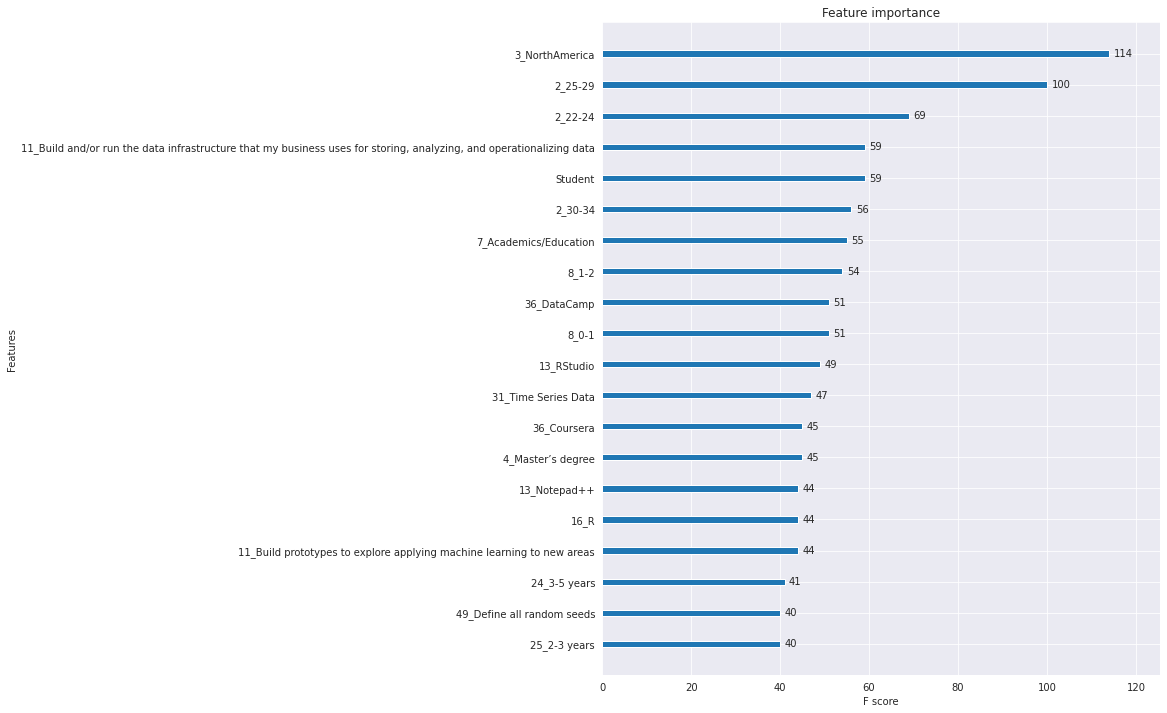

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_wrapper, ax=ax, max_num_features = 20)

* XGboost Variable Importance Matrix : 
* 역시 북미가 가장 큰 영향을 차지하는 것으로 나타남. 
* 그 뒤, 나이가 생각보다 많은 영향을 끼친 것으로 드러남. 
* 11번도 유의하게?
* 분야로는 Academic/Education이 유의하게 드러남
* 학생 변수 역시 연봉 예측에 중요한 변수. (나이와 아마 관련있을듯) 
* 주로 사용하는 Platform : Data camp가 유의하게 드러남. 
* 학위로는 Master's degree? (가설 1. -영향력, 가설 2. Manager 계통이 높은 연봉자들이 많이 분포되어있는데, 그들의 학위가 Master's degree에 더 많았다.)
* 언어로는 R
* IDE로는 RStudio 


=> **다만 이건 Xgboost의 Variable Importance Plot이므로 Logistic Regression이 택해질 경우 다른 결과가 드러날 가능성이 큼** 

** XGboost CV Score : 

In [ ]:
XGB_auc2 = cross_val_score(xgb_wrapper, X=Xg_train, y=y_train, scoring="roc_auc")
XGB_auc2

array([0.89303134, 0.89404279, 0.89600725, 0.88853265, 0.90436699])

In [ ]:
XGB_auc2.mean()

0.8951962023686144

In [ ]:
import xgboost as xgb

hr_dmatrix = xgb.DMatrix(data=Xg_train, label=y_train)

In [ ]:
cv_params = {"objective":"binary:logistic", 
             "n_estimators": 100,
             "max_depth":5}

hr_cv = xgb.cv(dtrain=hr_dmatrix, 
               params=cv_params, 
               nfold=5, 
               num_boost_round=10, 
               metrics="auc", 
               as_pandas=True)
hr_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.858837,0.005119,0.839913,0.007561
1,0.883342,0.003590,0.863886,0.005641
2,0.895942,0.004499,0.873064,0.003985
3,0.905298,0.001348,0.881549,0.003278
4,0.909607,0.001550,0.883881,0.003555
5,0.913671,0.001153,0.887022,0.004529
6,0.916633,0.001716,0.889856,0.004220
7,0.920626,0.001612,0.891688,0.004517
8,0.924712,0.001331,0.893379,0.004966
9,0.927808,0.002088,0.893884,0.004933


In [ ]:
XGB_cv_auc = hr_cv.iloc[:, 2].mean()
XGB_cv_auc

0.8798122599999999

## Model Comparison 


### By Cross Validation Score - AUC

In [ ]:
CV_table = pd.DataFrame()

CV_table.loc[1,'RF_cv_auc'] = RF_cv_score
CV_table['LR_cv_auc'] = LR_cv_score
CV_table['SVM_cv_auc'] = svm_scores.mean()
CV_table['XGB_cv_auc_cross_val'] = XGB_auc2.mean()
CV_table['XGB_cv_auc_xgb.cv'] = XGB_cv_auc

## Test Data Accuracy and ROC
Acc_table = pd.DataFrame()

Acc_table.loc[1,'RF_acc'] = RF_accuracy
Acc_table['LR_acc'] = LR_accuracy
Acc_table['SVM_acc'] = SVM_acc
Acc_table['XGB_acc'] = XGB_accuracy

AUC_table = pd.DataFrame()

AUC_table.loc[1,'RF_auc'] = RF_roc
AUC_table['LR_auc'] = LR_roc
AUC_table['SVM_auc'] = SVM_auc
AUC_table['XGB_cv_auc'] = XGB_auc


In [ ]:
CV_table

,RF_cv_auc,LR_cv_auc,SVM_cv_auc,XGB_cv_auc_cross_val,XGB_cv_auc_xgb.cv
1,0.886446,0.898521,0.895197,0.895196,0.879812


In [ ]:
Acc_table

,RF_acc,LR_acc,SVM_acc,XGB_acc
1,0.871206,0.877495,0.878316,0.875855


In [ ]:
AUC_table

,RF_auc,LR_auc,SVM_auc,XGB_cv_auc
1,0.883112,0.904257,0.901281,0.901808


* Final Result : 
- Cross validation 기준 : SVM or XGboost or Logistic Regression 중 선택. 
- Accuracy 기준 : SVM, LR, XGB 순서대로. 
- AUC 기준 : Logistic Regression이 Best 

=> 따라서, Logistic Regression 및 XGB로 Parameter Tuning 실시. 

In [ ]:
## How to plot a ROC Curve in Python
def Snippet_140():
    print()
    print(format('How to plot a ROC Curve in Python','*^82'))

    import warnings
    warnings.filterwarnings("ignore")

    # load libraries
    from sklearn.datasets import make_classification
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt

    # Create feature matrix and target vector
    X, y = make_classification(n_samples=10000, n_features=100, n_classes=2)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Create classifier
    clf1 = DecisionTreeClassifier(); clf2 = LogisticRegression();

    # Train model
    clf1.fit(X_train, y_train); clf2.fit(X_train, y_train);

    # Get predicted probabilities
    y_score1 = clf1.predict_proba(X_test)[:,1]
    y_score2 = clf2.predict_proba(X_test)[:,1]

    # Plot Receiving Operating Characteristic Curve
    # Create true and false positive rates
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
    print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))
    print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score2))

    # Plot ROC curves
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Logistic regression')
    plt.plot(false_positive_rate2, true_positive_rate2)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## Parameter Tuning 


* Logistic Regression Tuning : L1 penalty, C - cost value
* L1 Penalty 쓰는 이유 : dim = 245개 Variable, 효과 없는 변수들을 줄여 computational efficiency를 확보하기 위함. 


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Create a logistic regression object with an L1, ㅣ2 penalty
logistic = LogisticRegression(solver='liblinear')

pipe = Pipeline(steps=[('logistic', logistic)])

# Create Parameter Space

# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,x_train.shape[1]+1,1))

# Create a list of values of the regularization parameter
C = np.logspace(-4, 4, 50)
# Create a list of options for the regularization penalty
penalty = ['l1']
# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(logistic__C=C,
                  logistic__penalty=penalty)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(x_train, y_train)
    # View The Best Parameters
print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic__C'])
print(); print(clf.best_estimator_.get_params()['logistic'])

# Use Cross Validation To Evaluate Model - Accuracy
CV_Result = cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Penalty: l1
Best C: 0.3906939937054613

LogisticRegression(C=0.3906939937054613, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

[0.88107791 0.87580551 0.86818981 0.87397421 0.8862837 ]

0.8770662282265083

0.006180555958421008


In [ ]:
# Use Cross Validation To Evaluate Model = AUROC
CV_Result = cross_val_score(clf, x_train, y_train, cv=5, scoring='roc_auc')
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())


[0.90256594 0.90129376 0.90487878 0.89090233 0.91817088]

0.9035623360786259

0.008735647040665616


In [ ]:
Logistic = LogisticRegression(solver='liblinear', penalty = 'l1', C = clf.best_estimator_.get_params()['logistic__C'] )
Logistic.fit(x_train, y_train)

LR_pred = Logistic.predict(x_test)
LR_pred_score = Logistic.predict_proba(x_test)
# calculating metrics

LR_tuned_accuracy = accuracy_score(y_test, LR_pred)
LR_tuned_roc = roc_auc_score(y_test, pd.DataFrame(LR_pred_score)[1])

In [ ]:
print(LR_tuned_accuracy, LR_tuned_roc)

0.8791359037462401 0.9066322690630129


* 전부 tuning 전보다 미세하게나마 상승함. (Test accuracy, test AUC)



* XGB Hyper Parameter Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

# 초모수 격자생성
xgb_param_grid = {'max_depth': [3,5,7, 9], 
              'subsample': [0.6, 0.8, 1.0]}

# Create a GridSearchCV object
hr_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='roc_auc',
                       n_jobs=8,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

hr_grid.fit(Xg_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=8,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'subsample': [0.6, 0.8, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

In [ ]:
hr_grid_df = pd.DataFrame(hr_grid.cv_results_)
hr_grid_df.loc[:, ['mean_test_score', "params"]]

,mean_test_score,params
0,0.902882,"{'max_depth': 3, 'subsample': 0.6}"
1,0.903967,"{'max_depth': 3, 'subsample': 0.8}"
2,0.903798,"{'max_depth': 3, 'subsample': 1.0}"
3,0.900585,"{'max_depth': 5, 'subsample': 0.6}"
4,0.902640,"{'max_depth': 5, 'subsample': 0.8}"
5,0.901859,"{'max_depth': 5, 'subsample': 1.0}"
6,0.897899,"{'max_depth': 7, 'subsample': 0.6}"
7,0.900655,"{'max_depth': 7, 'subsample': 0.8}"
8,0.900121,"{'max_depth': 7, 'subsample': 1.0}"
9,0.899684,"{'max_depth': 9, 'subsample': 0.6}"


In [ ]:
hr_grid_df[hr_grid_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,24.816284,0.362425,0.109805,0.014674,3,0.8,"{'max_depth': 3, 'subsample': 0.8}",0.903105,0.898322,0.909646,0.891748,0.917015,0.903967,0.008768,1,0.933037,0.934247,0.932706,0.936424,0.931836,0.93365,0.001588


In [ ]:
## 최고성능
best_score = hr_grid.best_score_
# 최고성능을 내는 행을 찾아냄
best_row = hr_grid.best_index_

# 최적 초모수: max_depth, subsample
best_max_depth     = hr_grid.best_params_["max_depth"]
best_max_subsample = hr_grid.best_params_["subsample"]

nl = '\n'
print(f'Area Under ROC Cureve (AUC):  \t {best_score:.3f}{nl}\
        인덱스:           \t {best_row}{nl}\
        max_depth:      \t {best_max_depth}{nl}\
        subsample:      \t {best_max_subsample}')

Area Under ROC Cureve (AUC):  	 0.904
        인덱스:           	 1
        max_depth:      	 3
        subsample:      	 0.8


In [ ]:
xgb_tuned = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = best_max_depth,
                            eval_metric = "auc", early_stopping_rounds=100, subsample=best_max_subsample)
xgb_tuned.fit(Xg_train, y_train)
w_preds = xgb_tuned.predict(Xg_test)
w_pred_score = xgb_tuned.predict_proba(Xg_test)[:, 1]

In [ ]:
get_clf_eval(y_test, w_preds)
XGB_tuned_auc = roc_auc_score(y_test, w_pred_score)
print('AUC: {: .4f}'.format(XGB_tuned_auc))

오차행렬:
 [[2823  171]
 [ 276  387]]

정확도: 0.8778
정밀도: 0.6935
재현율: 0.5837
F1: 0.6339
AUC:  0.9058


In [ ]:
XGB_tuned_accuracy = accuracy_score(y_test, w_preds)
XGB_tuned_auc = roc_auc_score(y_test, w_pred_score)

In [ ]:
XGB_tuned_cv_Result = cross_val_score(xgb_tuned, Xg_train, y_train, cv=5, scoring='roc_auc')
XGB_tuned_cv_Result.mean()

0.8995773757511036

In [ ]:
print("_______Comparison from Former Logistic Regression______ \n")
print("* Accuracy : \n LR_accuracy = {}, LR_tuned_accuracy = {}" .format(LR_accuracy, LR_tuned_accuracy))
print("* Area Under Roc Curve : \n LR_auc = {}, LR_tuned_auc = {}" .format(LR_roc, LR_tuned_roc))
print("* Cross Validation Score : \n LR_cv_auc = {}, LR_cv_tuned_auc = {}" .format(LR_cv_score, CV_Result.mean()))

print("_______Comparison from Former XGBoost______ \n")
print("* Accuracy : \n XGB_accuracy = {}, XGB_tuned_accuracy = {}" .format(XGB_accuracy, XGB_tuned_accuracy))
print("* Area Under Roc Curve : \n XGB_auc = {}, XGB_tuned_auc = {}" .format(XGB_auc, XGB_tuned_auc))
print("* Cross Validation Score(using cross_val_score) : \n XGB_cv_auc = {}, XGB_cv_tuned_auc = {}" .format(XGB_auc2.mean(), XGB_tuned_cv_Result.mean()))
print("* Cross Validation Score(using GridSearchCV) : \n XGB_cv_auc = {}, XGB_cv_tuned_auc = {}" .format(XGB_cv_auc, best_score))

_______Comparison from Former Logistic Regression______ 

* Accuracy : 
 LR_accuracy = 0.8774952146568226, LR_tuned_accuracy = 0.8791359037462401
* Area Under Roc Curve : 
 LR_auc = 0.9042569805271679, LR_tuned_auc = 0.9066322690630129
* Cross Validation Score : 
 LR_cv_auc = 0.8985210065709577, LR_cv_tuned_auc = 0.9035623360786259
_______Comparison from Former XGBoost______ 

* Accuracy : 
 XGB_accuracy = 0.875854525567405, XGB_tuned_accuracy = 0.8777686628383922
* Area Under Roc Curve : 
 XGB_auc = 0.9018076373964621, XGB_tuned_auc = 0.9057677950168815
* Cross Validation Score(using cross_val_score) : 
 XGB_cv_auc = 0.8951962023686144, XGB_cv_tuned_auc = 0.8995773757511036
* Cross Validation Score(using GridSearchCV) : 
 XGB_cv_auc = 0.8798122599999999, XGB_cv_tuned_auc = 0.9039672758887729


## Final Model 선택 : 
- Logistic Regression이 test accuracy, cross validation score, test auc 모두에서 훨씬 더 높은 결과를 가져옴. 
- Logistic Regression을 최종 모델로 채택. 

In [ ]:
display_scores(Logistic, x_test, y_test)


### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[2831  163]
 [ 279  384]]
Accuracy:  0.8791359037462401
AUC:  0.9066322690630129
Type 1 error:  0.05444221776887107
Type 2 error:  0.42081447963800905


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, precision_recall_curve, roc_curve

In [ ]:
con_mat = confusion_matrix(y_test, LR_pred)
average_precision = average_precision_score(y_test, LR_pred)
cls_report = classification_report(y_test, LR_pred)

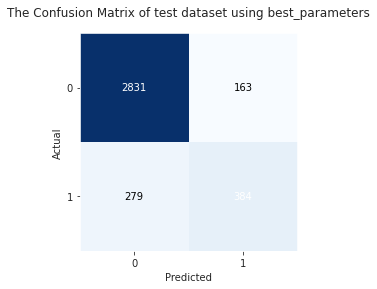

The accuracy is 87.91359037462401 %
The recall from the confusion matrix is 57.9185520361991 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


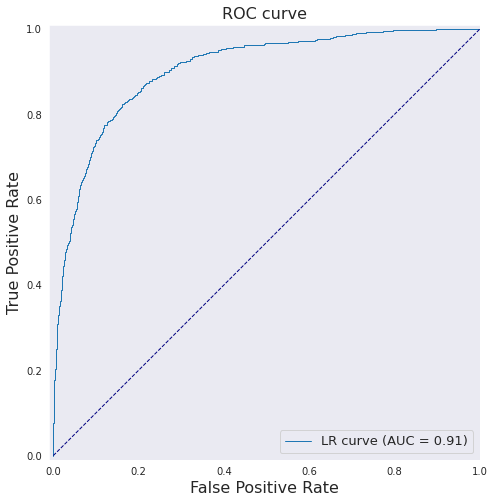

In [ ]:
def confus_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM)
    plt.title("The Confusion Matrix of test dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")
confus_matrix(con_mat)

fpr_rf, tpr_rf, _ = roc_curve(y_test, LR_pred_score[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('LR',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()


************************How to plot a ROC Curve in Python*************************
roc_auc_score for Logistic Regression:  0.9066322690630129


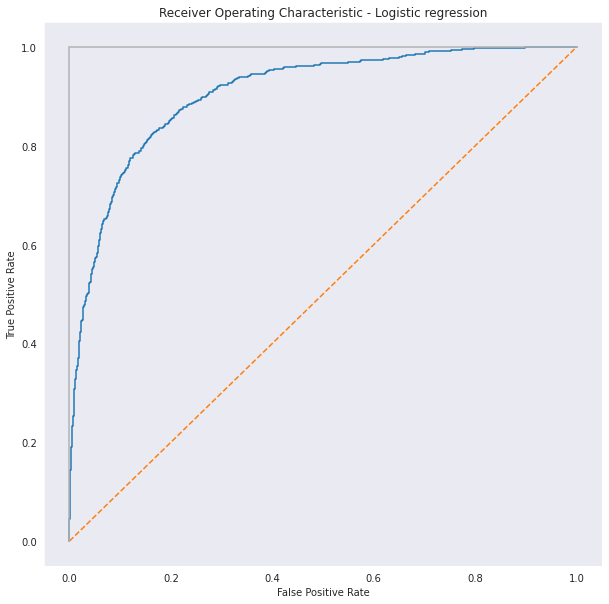

In [ ]:
print()
print(format('How to plot a ROC Curve in Python','*^82'))

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, LR_pred_score[:, 1])
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, LR_pred_score[:, 1]))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


* ROC curve graph : 

In [ ]:
print('Our model\'s intercept is:', Logistic.intercept_[0])

Our model's intercept is: -0.6486222052561649


= Intercept Starts with 0.___ => 여기에서 본인이 가진 특징으로 가감되어 최종 Top20안에 드는 연봉을 받을 수 있는가가 결정됨. 
* Psotive Coefficients : positive 답변이 Top 20% 연봉 안에 들 확률을 높인다.
* Negative Coefficients : positive 답변이 Top 20% 연봉 안에 들 확률을 낮춘다. 

* Coefficients 

In [ ]:
features1 = pd.DataFrame([x_train.columns, Logistic.coef_[0]]).transpose()
features1.columns = ['feature', 'coefficient']
features1.sort_values(by='coefficient', ascending = False)[0:20]

,feature,coefficient
9,3_NorthAmerica,2.16156
27,7_Accounting/Finance,0.442014
40,"10_We have well established ML methods (i.e., ...",0.431119
14,Consultant/Project/Manager,0.414387
12,4_Doctoral degree,0.390175
13,4_Master’s degree,0.318959
46,11_Build prototypes to explore applying machin...,0.312946
121,24_10-20 years,0.295971
183,38_FiveThirtyEight.com,0.295219
65,13_Other,0.269575


* Top 20  + Coef : 
1. North America(미국이 연봉 가장 높게 쳐줌) 
2. 재직분야 = Account/Finace (Finance 계통의 연봉이 높음)
3. 회사가 ML 방법론을 잘 정립했는가
4. 직업 중에선 Consultant/Project/Manager이 가장 높았음
5. 연봉 - Doctoral degree
6. 석사학위
7. 회사에세ㅓ ML 적용하려 prototype 구축하고있는가 역시 중요 
8. 코딩 경력 : 10-20년
9. 주로 DS topic 다루는 사이트 중 Five Thirty Eight.com을 선호한다. 
10. 12_Part_5 = What is the primary tool that you use at work or school to analyze data? (include text response) - Cloud-based data software & APIs (AWS, GCP, Azure, etc.) - Text
11. 일/학교에서 주로 사용하는 cloud service = AWS가 긍정적 영향
12. 고연봉자들은 What metrics do you or your organization use to determine whether or not your models were successful? (Select all that apply) - Selected Choice - Metrics that consider accuracy (성공적인 모델을 판단할 때, unfair bias를 고려하는 Metrics를 주로 선호하고, 그 뒤 Revenue and/or business goals를 많이 고려한다)
13. 19:ML framework used past 5 years : caffe. 강화학습/음성인식/멀티미디어/컴퓨터 비전 등에 쓰이는 framework - convolution architecture for fast embedding) 
14. AWS Labmda가 고연봉자들이 주로 많이 쓰는 cloud. 
**=> 요약 : 이로 보건데, Kaggle 상위 20%의 연봉을 가지고 있는 사람들의 경우 Account/Finance 분야 재직, 직업은 Consultant, Product/Project Manager, Manager 이 많이 포진된 듯 하다. (위 변수들이 + coef중 상위) 또한, Computer Science계통이 많이 분포된 듯 함. **


In [ ]:
features1 = pd.DataFrame([x_train.columns, Logistic.coef_[0]]).transpose()
features1.columns = ['feature', 'coefficient']
features1.sort_values(by='coefficient', ascending = True)[0:20]

,feature,coefficient
2,2_22-24,-2.09795
20,Student,-1.84717
3,2_25-29,-1.60979
1,2_18-21,-1.4298
26,7_Academics/Education,-1.14011
31,8_1-2,-1.01523
10,3_SouthAmerica,-0.981482
30,8_0-1,-0.974816
4,2_30-34,-0.881222
38,10_No (we do not use ML methods),-0.688916


- -coef 순위 : 
1. 나이가 어릴수록, 학생일수록 연봉에 부정적 영향을 미친다.
2. Academic/Education 재직 분야 역시 부정적 영향
3. 경험 없을수록 - 영향
4. 오히려 남미계통이 연봉에 부정적 영향을 줌.
5. 3-40대까지는 연봉에 부정적 영향
6. 회사가 ML methods 사용하지 않을 경우 연봉이 대체로 낮음
7. Data Analyst가 연봉에 부정적 영향을 가짐.
8. 코딩 경력 역시 낮을수록
9, PHP : 온라인 HTML 계통? 
10. 유럽 역시 연봉에 부정적 영향을 준다.
11. What methods do you prefer for explaining and/or interpreting decisions that are made by ML models? = 사용하지 않는다가 부정적 영향. 


In [ ]:
features = pd.DataFrame([x_train.columns, Logistic.coef_[0]]).transpose()
features.columns = ['feature', 'coefficient']
features['abs_coefficient'] = features['coefficient'].abs()

In [ ]:
features.iloc[0:15, :]

,feature,coefficient,abs_coefficient
0,1_Female,-0.150526,0.150526
1,2_18-21,-1.4298,1.4298
2,2_22-24,-2.09795,2.09795
3,2_25-29,-1.60979,1.60979
4,2_30-34,-0.881222,0.881222
5,2_35-39,-0.258906,0.258906
6,2_40-44,-0.305588,0.305588
7,3_Asia,-0.288701,0.288701
8,3_Europe,-0.387048,0.387048
9,3_NorthAmerica,2.16156,2.16156


In [ ]:
features.tail()

,feature,coefficient,abs_coefficient
238,48_I am confident that I can explain the outpu...,0,0
239,48_I am confident that I can understand and ex...,0.0779654,0.0779654
240,48_I do not know; I have no opinion on the matter,0,0
241,"48_I view ML models as ""black boxes"" but I am ...",-0.034584,0.034584
242,"48_Yes, most ML models are ""black boxes""",0,0


In [ ]:
features['question_number'] = features.feature.str.split('_').str[0]

features['answer'] = features.feature.str[2:]

features['answer'] = features.answer.apply(lambda x: x[1:] if x[0] == '-' else x)
features['question'] = features['question_number']

In [ ]:
features.iloc[40:60, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
40,"10_We have well established ML methods (i.e., ...",0.431119,0.431119,10,"_We have well established ML methods (i.e., mo...",10
41,"10_We recently started using ML methods (i.e.,...",0,0,10,"_We recently started using ML methods (i.e., m...",10
42,10_We use ML methods for generating insights (...,0.0814224,0.0814224,10,_We use ML methods for generating insights (bu...,10
43,11_Analyze and understand data to influence pr...,0.0192887,0.0192887,11,_Analyze and understand data to influence prod...,11
44,11_Build and/or run a machine learning service...,0.135077,0.135077,11,_Build and/or run a machine learning service t...,11
45,11_Build and/or run the data infrastructure th...,0,0,11,_Build and/or run the data infrastructure that...,11
46,11_Build prototypes to explore applying machin...,0.312946,0.312946,11,_Build prototypes to explore applying machine ...,11
47,11_Do research that advances the state of the ...,0,0,11,_Do research that advances the state of the ar...,11
48,11_Other,0,0,11,_Other,11
49,12_Q12_Part_2_TEXT,-0.0839618,0.0839618,12,_Q12_Part_2_TEXT,12


In [ ]:
import plotly.graph_objects as go


* Q3 - country

In [ ]:
Q3_data = features.iloc[7:11, :]
Q3_data
title = "3_What is Your Role?"
barplot = Q3_data[['feature', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = False)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q3_data.feature, y = Q3_data.coefficient)])
fig.show()

* Q6 - Role 

In [ ]:
features.iloc[15:21, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
15,Data Analyst,-0.507038,0.507038,Data Analyst,ta Analyst,Data Analyst
16,Data Scientist,0.082294,0.082294,Data Scientist,ta Scientist,Data Scientist
17,Other,0.0556964,0.0556964,Other,her,Other
18,Software Engineer,0.142813,0.142813,Software Engineer,ftware Engineer,Software Engineer
19,Statistician/Research Scientist,-0.0470107,0.0470107,Statistician/Research Scientist,atistician/Research Scientist,Statistician/Research Scientist
20,Student,-1.84717,1.84717,Student,udent,Student


In [ ]:
Q6_data = features.iloc[14:20, :]
Q6_data
title = "6_What is Your Role?"
barplot = Q6_data[['feature', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = False)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q6_data.feature, y = Q6_data.coefficient)])
fig.show()

* L1 Penalty : 효과가 미미한 경우 0으로 보내버림. 

---

따라서 Othres의 효과가 0으로 당겨져버림.
* Consultant/Project, Product Manager/ Manager들이 연봉이 높음과 양의 방향으로 coef. 
* Data Analyst가 낮게 나왔음.
* Data scientist 의 영향이 미미
* Software Engineer 이 생각보다 높게 나옴,

**=> 고액연봉자들 중에선, DS보단 Account/Finantial 분야 + Computer Science 분야 사람들이 많이 포함되어 있었다.**

* Q13 - 주로 쓰는 IDE

In [ ]:
features.iloc[54:67, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
54,13_RStudio,-0.146554,0.146554,13,_RStudio,13
55,13_PyCharm,0.024232,0.024232,13,_PyCharm,13
56,13_Visual Studio Code,0.130163,0.130163,13,_Visual Studio Code,13
57,13_Atom,0,0,13,_Atom,13
58,13_MATLAB,-0.0149239,0.0149239,13,_MATLAB,13
59,13_Visual Studio,-0.0434462,0.0434462,13,_Visual Studio,13
60,13_Notepad++,-0.216855,0.216855,13,_Notepad++,13
61,13_Sublime Text,0.0240433,0.0240433,13,_Sublime Text,13
62,13_Vim,0,0,13,_Vim,13
63,13_IntelliJ,0,0,13,_IntelliJ,13


In [ ]:
Q13_data = features.iloc[53:66, :]
title = "13_What is IDE?"
barplot = Q13_data[['feature', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = False)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q13_data.feature, y = Q13_data.coefficient)])
fig.show()

* 주로 사용한 IDE = Pycharm, Visual Studio Code가 유의
* Rstudio, Notepad ++, Visual Studio 모두 negative corr

* Q4 : Degree

In [ ]:
features.iloc[11:14, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
11,4_Bachelor’s degree,0,0,4,Bachelor’s degree,4
12,4_Doctoral degree,0.390175,0.390175,4,Doctoral degree,4
13,4_Master’s degree,0.318959,0.318959,4,Master’s degree,4


In [ ]:
Q4_data = features.iloc[11:14, :]
Q4_data
title = "4_What is the Highest Level of formal education that you have attained or plan to attain within the next 2 years?"
barplot = Q4_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = False)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q4_data.answer, y = Q4_data.coefficient)])
fig.show()

* Bachelor's degree는 비교적 효과 없음으로 드러남. Doctoral과 Master's degree 는 top 20% 연봉에 유의한 결과를 드러냄. 

* Q7 : Industry 

In [ ]:
features.iloc[25:31, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
25,5_Physics or astronomy,0,0,5,Physics or astronomy,5
26,7_Academics/Education,-1.14011,1.14011,7,Academics/Education,7
27,7_Accounting/Finance,0.442014,0.442014,7,Accounting/Finance,7
28,7_Computers/Technology,0,0,7,Computers/Technology,7
29,7_Other,0.00186504,0.00186504,7,Other,7
30,8_0-1,-0.974816,0.974816,8,0-1,8


In [ ]:
Q7_data = features.iloc[26:30, :]

title = "7_How many years of experience do you have in your current role?"
barplot = Q7_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q7_data.answer, y = Q7_data.coefficient)])
fig.show()

* Q8 - Experience in current Role 

In [ ]:
features.iloc[30:39, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
30,8_0-1,-0.974816,0.974816,8,0-1,8
31,8_1-2,-1.01523,1.01523,8,1-2,8
32,8_10-15,-0.176547,0.176547,8,10-15,8
33,8_2-3,-0.653406,0.653406,8,2-3,8
34,8_3-4,-0.585324,0.585324,8,3-4,8
35,8_4-5,-0.423704,0.423704,8,4-5,8
36,8_5-10,-0.315156,0.315156,8,5-10,8
37,10_I do not know,-0.215511,0.215511,10,_I do not know,10
38,10_No (we do not use ML methods),-0.688916,0.688916,10,_No (we do not use ML methods),10


In [ ]:
Q8_data = features.iloc[30:37, :]
Q8_data = Q8_data.astype(object)

title = "8_How many years of experience do you have in your current role?"
barplot = Q8_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q8_data.answer, y = Q8_data.coefficient)])
fig.show()

* 전부 Negative coefficients.
* 5~10년, 10-15년 경력이 그래도 가장 작은 coef
* 높은 경력자 = 많은 연봉. 

* Q10 - 회사에서 ML 방법론 잘 사용중? 

In [ ]:
features.iloc[36:44, :]


,feature,coefficient,abs_coefficient,question_number,answer,question
36,8_5-10,-0.315156,0.315156,8,5-10,8
37,10_I do not know,-0.215511,0.215511,10,_I do not know,10
38,10_No (we do not use ML methods),-0.688916,0.688916,10,_No (we do not use ML methods),10
39,10_We are exploring ML methods (and may one da...,-0.0227467,0.0227467,10,_We are exploring ML methods (and may one day ...,10
40,"10_We have well established ML methods (i.e., ...",0.431119,0.431119,10,"_We have well established ML methods (i.e., mo...",10
41,"10_We recently started using ML methods (i.e.,...",0,0,10,"_We recently started using ML methods (i.e., m...",10
42,10_We use ML methods for generating insights (...,0.0814224,0.0814224,10,_We use ML methods for generating insights (bu...,10
43,11_Analyze and understand data to influence pr...,0.0192887,0.0192887,11,_Analyze and understand data to influence prod...,11


In [ ]:
Q10_data = features.iloc[37:43, :]

title = "10_Select any activities that make up an important part of your role at work"
barplot = Q10_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q10_data.answer, y = Q10_data.coefficient)])
fig.show()

* Q11

In [ ]:
features.iloc[42:50, :]


,feature,coefficient,abs_coefficient,question_number,answer,question
42,10_We use ML methods for generating insights (...,0.0814224,0.0814224,10,_We use ML methods for generating insights (bu...,10
43,11_Analyze and understand data to influence pr...,0.0192887,0.0192887,11,_Analyze and understand data to influence prod...,11
44,11_Build and/or run a machine learning service...,0.135077,0.135077,11,_Build and/or run a machine learning service t...,11
45,11_Build and/or run the data infrastructure th...,0,0,11,_Build and/or run the data infrastructure that...,11
46,11_Build prototypes to explore applying machin...,0.312946,0.312946,11,_Build prototypes to explore applying machine ...,11
47,11_Do research that advances the state of the ...,0,0,11,_Do research that advances the state of the ar...,11
48,11_Other,0,0,11,_Other,11
49,12_Q12_Part_2_TEXT,-0.0839618,0.0839618,12,_Q12_Part_2_TEXT,12


In [ ]:
Q11_data = features.iloc[43:49, :]

title = "11_Select any activities that make up an important part of your role at work"
barplot = Q11_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q11_data.answer, y = Q11_data.coefficient)])
fig.show()

* Building Prototype to explore ML to new areas 가 가장 높은 coef를 갖는 것으로 나타남. 
* 그 뒤로는 Build and/or run a service that operationally ~~


* Q12 - 데이터 분석에 주로 사용하는 도구. (큰 분류) 

In [ ]:
Q12_data = features.iloc[49:53, :]

title = "12_"
barplot = Q12_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q12_data.answer, y = Q12_data.coefficient)])
fig.show()

* Part 5 = 

* Q16 - 주로 사용하는 프로그래밍 언어 

In [ ]:
features.iloc[77:91, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
77,16_Python,-0.0854172,0.0854172,16,_Python,16
78,16_R,-0.0069572,0.0069572,16,_R,16
79,16_SQL,0,0,16,_SQL,16
80,16_Bash,0.0631942,0.0631942,16,_Bash,16
81,16_Java,0.000843016,0.000843016,16,_Java,16
82,16_Javascript/Typescript,0.0742061,0.0742061,16,_Javascript/Typescript,16
83,16_Visual Basic/VBA,-0.132338,0.132338,16,_Visual Basic/VBA,16
84,16_C/C++,0.0865244,0.0865244,16,_C/C++,16
85,16_MATLAB,0,0,16,_MATLAB,16
86,16_C#/.NET,-0.0524814,0.0524814,16,_C#/.NET,16


In [ ]:
Q16_data = features.iloc[77:89, :]

title = "12_"
barplot = Q16_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q16_data.answer, y = Q16_data.coefficient)])
fig.show()

* Python, R, 모두 - coef
* 오히려 Bash, Javascript, C/C++, 등이 + coef
* 이걸로 보건데, DS 보다는 전문분야 or 전문 프로그래머 Software engineer가 더 높은 연봉. 

* Q 19

In [ ]:
features.iloc[89:105, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
89,19_Scikit-Learn,0.0799148,0.0799148,19,_Scikit-Learn,19
90,19_TensorFlow,-0.0535231,0.0535231,19,_TensorFlow,19
91,19_Keras,0.0743274,0.0743274,19,_Keras,19
92,19_PyTorch,0,0,19,_PyTorch,19
93,19_Spark MLlib,0.0905413,0.0905413,19,_Spark MLlib,19
94,19_H20,0.134536,0.134536,19,_H20,19
95,19_Fastai,0.185255,0.185255,19,_Fastai,19
96,19_Caret,0,0,19,_Caret,19
97,19_Xgboost,0.0293653,0.0293653,19,_Xgboost,19
98,19_randomForest,0.0689184,0.0689184,19,_randomForest,19


In [ ]:
Q19_data = features.iloc[89:103, :]

title = "19_"
barplot = Q16_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q19_data.answer, y = Q19_data.coefficient)])
fig.show()

* 5년간 사용해본 ML frameworks : 
* 최근 트렌드 : Keras, H20, Fastai, 
* 전통 : Xgboost, RandomForest, Lightgbm
* caffe?는 뭐지?? 

* Q21

In [ ]:
features.iloc[103:113, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
103,21_ggplot2,0,0,21,_ggplot2,21
104,21_Matplotlib,0,0,21,_Matplotlib,21
105,21_Shiny,0,0,21,_Shiny,21
106,21_D3,0.102733,0.102733,21,_D3,21
107,21_Plotly,-0.204225,0.204225,21,_Plotly,21
108,21_Bokeh,0.0199684,0.0199684,21,_Bokeh,21
109,21_Seaborn,0.0204948,0.0204948,21,_Seaborn,21
110,21_Leaflet,-0.166266,0.166266,21,_Leaflet,21
111,21_Lattice,0.0810231,0.0810231,21,_Lattice,21
112,21_None,0.142478,0.142478,21,_None,21


In [ ]:
Q21_data =features.iloc[103:113, :]

title = "23_"
barplot = Q21_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q21_data.answer, y = Q21_data.coefficient)])
fig.show()

* 상위 20% 연봉을 받는 kaggler들은 D3, Bokeh, Seaborn, Lattice(R) 등을 사용하는 경우가 많았다. 
* 위 ggplot2, matplotlib은 corr이 0.5 부근으로, 다소 높았는데, Lasso가 자체적으로 0으로 당겨줌. 

*Q23 - 코딩에 투자하는 시간 비중 : 

In [ ]:
features.iloc[113:118, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
113,23_1% to 25% of my time,0,0,23,_1% to 25% of my time,23
114,23_25% to 49% of my time,-0.0337899,0.0337899,23,_25% to 49% of my time,23
115,23_50% to 74% of my time,-0.130199,0.130199,23,_50% to 74% of my time,23
116,23_75% to 99% of my time,-0.179801,0.179801,23,_75% to 99% of my time,23
117,24_< 1 year,-0.386503,0.386503,24,_< 1 year,24


In [ ]:
Q23_data =features.iloc[113:117, :]

title = "23_"
barplot = Q23_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q23_data.answer, y = Q23_data.coefficient)])
fig.show()

* 고연봉자들은 코딩 하는 시간이 짧다??
* 가설 1. Finance/Consulting 분야들이기 때문에 coding보단 결과 해석/논의시간이 더 길 것
* 가설 2. 잘하는 사람들이라서 코딩 금방 짧게 끝냄.  

 * 24 : 데이터 분석을 위해 코딩을 해 온 경력 : 

In [ ]:
Q24_data = features.iloc[117:127, :]
title = "Q24"
barplot = Q24_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q24_data.answer, y = Q24_data.coefficient)])
fig.show()

* 코딩 경력 = 많을 수록 좋은 salary.
* 보통 코딩 경력 낮을 수록 연봉 top 20% 안에 들어갈 확률에 -값을 더함. 

* Q26 - confidenc

In [ ]:
features.iloc[127:132, :]


,feature,coefficient,abs_coefficient,question_number,answer,question
127,25_I have never studied machine learning but p...,0,0,25,_I have never studied machine learning but pla...,25
128,26_Definitely not,0.118633,0.118633,26,_Definitely not,26
129,26_Definitely yes,-0.0629307,0.0629307,26,_Definitely yes,26
130,26_Maybe,0,0,26,_Maybe,26
131,27_AWS Elastic Compute Cloud (EC2),0,0,27,_AWS Elastic Compute Cloud (EC2),27


In [ ]:
Q26_data = features.iloc[128:131, :]

title = "Q26"
barplot = Q26_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q26_data.answer, y = Q26_data.coefficient)])
fig.show()

오히려 Confidence가 높을수록 연봉적으론 낮음. 
- 특징 : 높은 경력자들이 오히려 Maybe 쪽에다 투표. 
- 고액연봉자 = Computer science, Consulting/Manager 계통에 많다보니 스스로를 Data Scientist라고 생각하지 않는 경향도 존재. 다만, 효과가 매우 미미. 

* Q27 - 근 5년간 사용해 본 cloud computing products

In [ ]:
features.iloc[131:139, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
131,27_AWS Elastic Compute Cloud (EC2),0,0,27,_AWS Elastic Compute Cloud (EC2),27
132,27_Google Compute Engine,0,0,27,_Google Compute Engine,27
133,27_Google App Engine,0.14817,0.14817,27,_Google App Engine,27
134,27_AWS Lambda,0.199684,0.199684,27,_AWS Lambda,27
135,27_Google Cloud Functions,-0.187329,0.187329,27,_Google Cloud Functions,27
136,27_Azure Virtual Machines,-0.0885608,0.0885608,27,_Azure Virtual Machines,27
137,27_None,0,0,27,_None,27
138,28_SAS,-0.087578,0.087578,28,_SAS,28


In [ ]:
Q27_data = features.iloc[131:138, :]

title = "Q27"
barplot = Q27_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q27_data.answer, y = Q27_data.coefficient)])
fig.show()

* Q28, 30 => 5년간 사용한 ML product, Big Data Product 

In [ ]:
features.iloc[138:145, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
138,28_SAS,-0.087578,0.087578,28,_SAS,28
139,28_None,-0.0438718,0.0438718,28,_None,28
140,28_AWS,0.113081,0.113081,28,_AWS,28
141,28_Google,0,0,28,_Google,28
142,28_IBM,0,0,28,_IBM,28
143,28_Azure,0.00155011,0.00155011,28,_Azure,28
144,29_MySQL,0,0,29,_MySQL,29


In [ ]:
Q28_data = features.iloc[138:144, :]

title = "Q28"
barplot = Q28_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q28_data.answer, y = Q28_data.coefficient)])
fig.show()

* AWS 계통 ML 프로덕트 쓰는 사람이 더 많았다.
* Sas는 - coef, 하지만 주의해야 하는 것은 Kagglers를 대상으로 했기 때문에, SAS를 사용하는 사람이 적다는 것. 

In [ ]:
Q30_data = features.iloc[154:157, :]

title = "Q30"
barplot = Q30_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q30_data.answer, y = Q30_data.coefficient)])
fig.show()

주로 상위 20% 연봉 kaggler들이 사용한 cloud 상품 = AWS Lambda, Google app engine. 

* Q 42 성공적 모델 판단할 때 사용하는 판단기준 

In [ ]:
features.iloc[190:195, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
190,38_Other,-0.304729,0.304729,38,_Other,38
191,42_Revenue and/or business goals,0.229556,0.229556,42,_Revenue and/or business goals,42
192,42_Metrics that consider accuracy,-0.132659,0.132659,42,_Metrics that consider accuracy,42
193,42_Metrics that consider unfair bias,0.256288,0.256288,42,_Metrics that consider unfair bias,42
194,42_Not applicable (I am not involved with an o...,0.0608069,0.0608069,42,_Not applicable (I am not involved with an org...,42


In [ ]:
Q42_data = features.iloc[191:195, :]

title = "Q42"
barplot = Q42_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q42_data.answer, y = Q42_data.coefficient)])
fig.show()

* 성공적 모델 판단 사용 기준 : 
Revenue and/ir business goals / Metrics that consider unfair bias 


* Q36 : on which online platforms have you begun or complete data science cources?

In [ ]:
features.iloc[167:178, :]


,feature,coefficient,abs_coefficient,question_number,answer,question
167,36_Udacity,0.143298,0.143298,36,_Udacity,36
168,36_Coursera,0.0448425,0.0448425,36,_Coursera,36
169,36_edX,0,0,36,_edX,36
170,36_DataCamp,-0.176969,0.176969,36,_DataCamp,36
171,36_Kaggle Learn,-0.257843,0.257843,36,_Kaggle Learn,36
172,36_Fast.AI,0,0,36,_Fast.AI,36
173,36_developers.google.com,-0.0345343,0.0345343,36,_developers.google.com,36
174,36_Udemy,-0.145373,0.145373,36,_Udemy,36
175,36_Online University Courses,0.146701,0.146701,36,_Online University Courses,36
176,36_None,0.18437,0.18437,36,_None,36


In [ ]:
Q36_data = features.iloc[167:178, :]

title = "Q36"
barplot = Q36_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q36_data.answer, y = Q36_data.coefficient)])
fig.show()

* Udacity - positive corr to top 20% salary kaggers. 
* Udemy, Datacamp - negative coef to top 20% salary kagglers => I guess, 초보자들이 많이 듣는 강의사이트? 

* Q31 - Which types of data do you currently interact with most often at work or school?

In [ ]:
Q31_data = features.iloc[157:167:, :]
title = "Q31"
barplot = Q31_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q31_data.answer, y = Q31_data.coefficient)])
fig.show()

* top 20% 연봉 kagglers - 주로 Geospatial Data, Time Series, Video, Categorical Data를 다룸,
* 전문가 = 고학력자 = 특수 분야 이렇게 연관성이 있는듯 하다. 
* Text data, Numeric Data ; 상당히 낮은 coefficients


* Q40 : Which better demonstrates expertise in data science : academic achievement or independent projects? 


In [ ]:
features.iloc[235:248, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
235,40_Independent projects are equally important ...,-0.0295538,0.0295538,40,_Independent projects are equally important as...,40
236,40_Independent projects are much more importan...,0.0112905,0.0112905,40,_Independent projects are much more important ...,40
237,40_Independent projects are slightly more impo...,0,0,40,_Independent projects are slightly more import...,40
238,48_I am confident that I can explain the outpu...,0,0,48,_I am confident that I can explain the outputs...,48
239,48_I am confident that I can understand and ex...,0.0779654,0.0779654,48,_I am confident that I can understand and expl...,48
240,48_I do not know; I have no opinion on the matter,0,0,48,_I do not know; I have no opinion on the matter,48
241,"48_I view ML models as ""black boxes"" but I am ...",-0.034584,0.034584,48,"_I view ML models as ""black boxes"" but I am co...",48
242,"48_Yes, most ML models are ""black boxes""",0,0,48,"_Yes, most ML models are ""black boxes""",48


In [ ]:
Q40_data = features.iloc[235:238, :]
title = "Q40"
barplot = Q40_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q40_data.answer, y = Q40_data.coefficient)])
fig.show()

Top 20% dont' think independent projects are equally important as academic achievement. 

*Q47 - ML 모델로부터 나온 결과 설명, 해석시 선호하는 방법 : 

In [ ]:
features.iloc[206:219, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
206,47_Examine individual model coefficients,0.00358539,0.00358539,47,_Examine individual model coefficients,47
207,47_Examine feature correlations,-0.271454,0.271454,47,_Examine feature correlations,47
208,47_Examine feature importances,0.0486381,0.0486381,47,_Examine feature importances,47
209,47_Plot decision boundaries,0,0,47,_Plot decision boundaries,47
210,47_Create partial dependence plots,0.116791,0.116791,47,_Create partial dependence plots,47
211,47_Dimensionality reduction techniques,0,0,47,_Dimensionality reduction techniques,47
212,47_Attention mapping/saliency mapping,0,0,47,_Attention mapping/saliency mapping,47
213,47_Plot predicted vs. actual results,0,0,47,_Plot predicted vs. actual results,47
214,47_Print out a decision tree,-0.0274386,0.0274386,47,_Print out a decision tree,47
215,47_Sensitivity analysis/perturbation importance,0.145244,0.145244,47,_Sensitivity analysis/perturbation importance,47


In [ ]:
Q47_data = features.iloc[206:218, :]
title = "Q47"
barplot = Q40_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q47_data.answer, y = Q47_data.coefficient)])
fig.show()

* Feature Correlation만 봐서는 고액 연봉을 받는 분석가가 될 수 없다. Feature Importance와, Partial dependence, sensitivity analysis, pertubation importance, Lime functions 등을 다양하게 다룰 줄 알아야 함. 

* Q48 : ML 모델들을 설명이 난해한 결과를 생각하는 Black box 라고 생각하는가? 4개 척도. 

In [ ]:
features.iloc[238:, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
238,48_I am confident that I can explain the outpu...,0,0,48,_I am confident that I can explain the outputs...,48
239,48_I am confident that I can understand and ex...,0.0779654,0.0779654,48,_I am confident that I can understand and expl...,48
240,48_I do not know; I have no opinion on the matter,0,0,48,_I do not know; I have no opinion on the matter,48
241,"48_I view ML models as ""black boxes"" but I am ...",-0.034584,0.034584,48,"_I view ML models as ""black boxes"" but I am co...",48
242,"48_Yes, most ML models are ""black boxes""",0,0,48,"_Yes, most ML models are ""black boxes""",48


In [ ]:
Q48_data = features.iloc[238:, :]
title = "Q48"
barplot = Q40_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q48_data.answer, y = Q48_data.coefficient)])
fig.show()

* 많은 ML 알고리즘에 대해 이해하고 설명하는데 자신감이 있지만, 전부는 아니다가 + coef 
* ML모델을 Black Box라고 여기지만, experts는 모델 결과를 해석할 수 있으리라 본다는 - coef 

* Variable importance Plot 

In [ ]:
index_clean = clean_dataset.columns[2:]
index_clean

Index(['1_Female', '2_18-21', '2_22-24', '2_25-29', '2_30-34', '2_35-39',
       '2_40-44', '3_Asia', '3_Europe', '3_NorthAmerica',
       ...
       '50_I had never considered making my work easier for others to reproduce',
       '50_None of these reasons apply to me',
       '40_Independent projects are equally important as academic achievements',
       '40_Independent projects are much more important than academic achievements',
       '40_Independent projects are slightly more important than academic achievements',
       '48_I am confident that I can explain the outputs of most if not all ML models',
       '48_I am confident that I can understand and explain the outputs of many but not all ML models',
       '48_I do not know; I have no opinion on the matter',
       '48_I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
       '48_Yes, most ML models are "black boxes"'],
      dtype='object', length=243)

In [ ]:
feature_imp = pd.Series(rforest.feature_importances_, index=index_clean).sort_values(ascending = False)
feature_imp[0:20]

3_NorthAmerica                                                                               0.095370
3_Asia                                                                                       0.016436
24_10-20 years                                                                               0.014890
3_Europe                                                                                     0.012361
Student                                                                                      0.011511
2_22-24                                                                                      0.011362
10_We have well established ML methods (i.e., models in production for more than 2 years)    0.011022
15_Amazon Web Services (AWS)                                                                 0.010948
11_Build prototypes to explore applying machine learning to new areas                        0.010331
2_25-29                                                                           

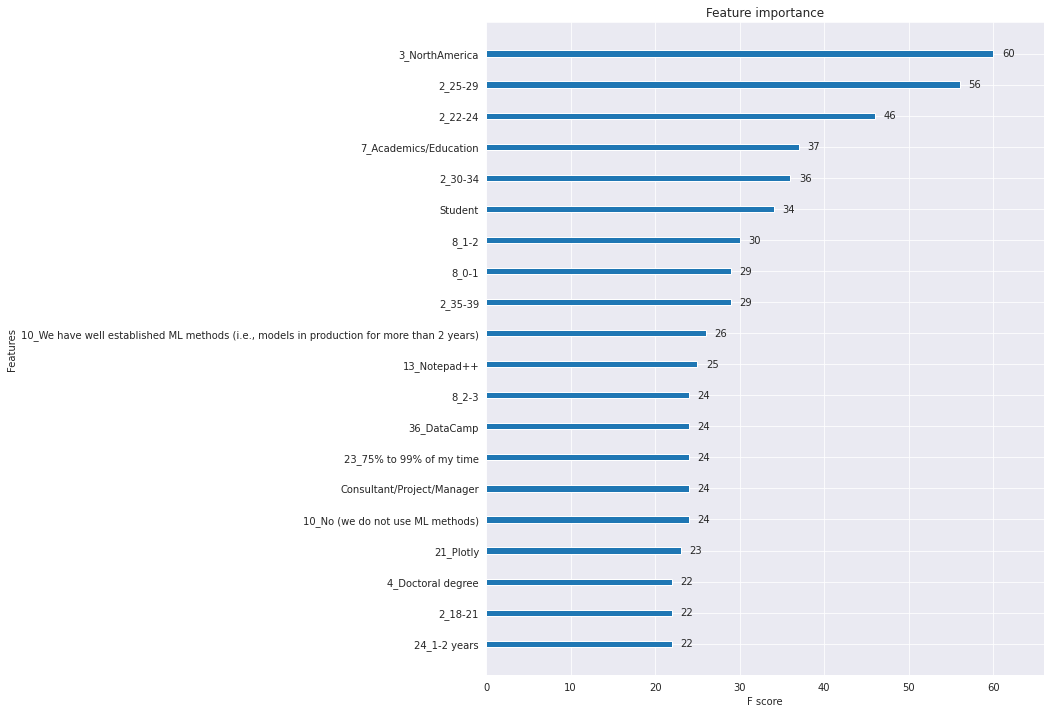

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_tuned, ax=ax, max_num_features = 20)